# Models

## Data Preparation

### Load all modules and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score

### Load the dataset

In [2]:
aml_df = pd.read_csv("aml_df.csv")

### Create a mirror dataset

In [3]:
aml_mirror_true_df = aml_df.loc[aml_df["AML_Label"]==1].sample(n=130, random_state=1)
aml_mirror_false_df = aml_df.loc[aml_df["AML_Label"]==0].sample(n=99870, random_state=1)
aml_mirror_df = pd.concat([aml_mirror_true_df, aml_mirror_false_df])

### Split the mirror dataset

In [4]:
X_mirror, y_mirror = aml_mirror_df.iloc[:, :-1], aml_mirror_df.iloc[:, -1:]

In [5]:
X_train_mirror, X_test_mirror, y_train_mirror, y_test_mirror = train_test_split(X_mirror, y_mirror, 
                                                    test_size=0.3, 
                                                    random_state=1)

### Address the Class Imbalance

#### Split the dataset into independent and target datasets

In [6]:
X, y = aml_df.iloc[:, :-1], aml_df.iloc[:, -1:]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1,
                                                    stratify=y)

#### Undersampling

Use RandomUnderSampler function to randomly draw the same number of samples from the majority class as the minority class.

In [8]:
undersample = RandomUnderSampler(random_state=1)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

#### Oversampling

Use loc to draw 12,000 samples from the minority class with replacement and 50,000 from the majority class to create the oversampled dataset.

In [9]:
aml_df_over = pd.concat([X_train, y_train], axis=1)
aml_true_df = aml_df_over.loc[aml_df_over["AML_Label"]==1].sample(n=12000, random_state=1, replace=True)
aml_false_df = aml_df_over.loc[aml_df_over["AML_Label"]==0].sample(n=50000, random_state=1)
aml_df_over = pd.concat([aml_true_df, aml_false_df])
X_train_over = aml_df_over.iloc[:, :-1]
y_train_over = aml_df_over.iloc[:, -1:]

#### SMOTE

Use the SMOTETomek function to create a synthetic dataset which synthetically creates a dataset with fifty percent from the minority class.

In [373]:
%%time

aml_true_df = aml_df.loc[aml_df["AML_Label"]==1]
aml_false_df = aml_df.loc[aml_df["AML_Label"]==0].sample(n=50000, random_state=1)
aml_df = pd.concat([aml_true_df, aml_false_df])
X, y = aml_df.iloc[:, :-1], aml_df.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1,
                                                    stratify=y)
smote = SMOTETomek(sampling_strategy=0.50, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Wall time: 1.01 s


## Logistic Regression

### Baseline Model

Create the baseline model to measure each of the remaining Logistic Regression models against

#### Grid Search Cross Validation for Logistic Regression

Use grid search cross validation to search through the hyperparameters to find the best accuracy for the baseline model.

In [131]:
%%time

param_C = [0.001, 0.01, 0.1, 1.0]
lr_grid = [{'LR__penalty':['l1', 'l2'],
           'LR__C':param_C}]

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(solver='saga', random_state=1, class_weight='balanced', max_iter=3000))])

lr_grid_cv = GridSearchCV(estimator=pipe_lr, param_grid=lr_grid, scoring='accuracy', cv=5, n_jobs=-1)

lr_gs = lr_grid_cv.fit(X_train_mirror, np.ravel(y_train_mirror))
print('Logistic Regression Best Parameters: {}'.format(lr_gs.best_params_))
print('Logistic Regression Train Accuracy: {:.6f}'.format(lr_gs.best_score_))

Logistic Regression Best Parameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Logistic Regression Train Accuracy: 0.922029
Wall time: 3min 38s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Find the Test Accuracy, Precision and Recall for the best baseline Logisitic Regression model

In [132]:
%%time

lr_best_clf = lr_gs.best_estimator_
lr_best_clf.fit(X_train, np.ravel(y_train))
lr_best_pred = lr_best_clf.predict(X_test)

print('Logistic Regression Test Accuracy: {:.6f}'.format(lr_best_clf.score(X_test, y_test)))
print('Logistic Regression Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=lr_best_pred)))
print('Logistic Regression Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=lr_best_pred)))

Logistic Regression Test Accuracy: 0.931459
Logistic Regression Test Precision: 0.686378
Logistic Regression Test Recall: 0.946834
Wall time: 24.4 s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### K-Fold Cross Validation for Logistic Regression Baseline

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Logistic Regression baseline model

In [151]:
%%time

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(C=1.0, penalty='l1', solver='saga', class_weight='balanced', random_state=1, max_iter=2000))])

val_scores = cross_val_score(estimator=pipe_lr,
                              X=X_train_mirror,
                              y=np.ravel(y_train_mirror),
                              cv=10,
                              n_jobs=-1)

print('Baseline Logistic Regression CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(val_scores), np.std(val_scores)))

Baseline Logistic Regression CV Accuracy: 0.919 +/- 0.004
Wall time: 1min 6s


#### Learning Curve for Logistic Regression Baseline

Create a learning curve for the Logistic Regression baseline model to measure the training and validation accuracies based on the number of training samples.

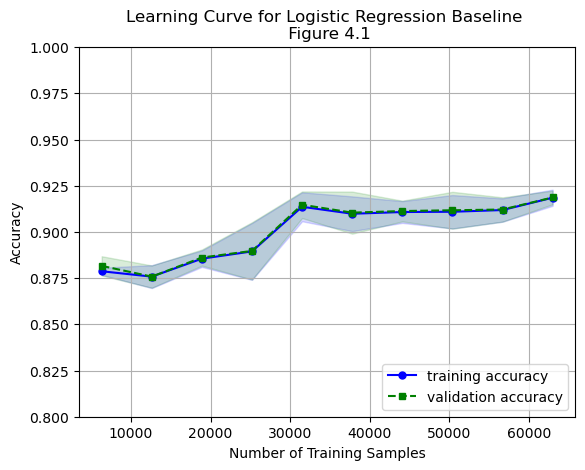

Wall time: 5min 27s


In [152]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train_mirror,
                                                        y=np.ravel(y_train_mirror),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Logistic Regression Baseline \n Figure 4.1', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show( )

#### Validation Curve for Logistic Regression

Create a validation curve for the basline Logistic Regression model to measure the training and validation accuracies for the C parameter.

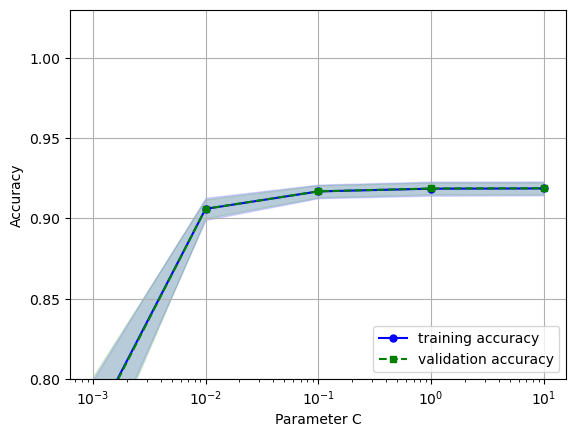

Wall time: 4min 32s


In [153]:
%%time

param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train_mirror,
                                            y=np.ravel(y_train_mirror),
                                            param_name='LR__C',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Baseline Standardized Model Confusion Matrix

Create a confusion matrix to plot the number of true positive, false positive, true negative and false negative.

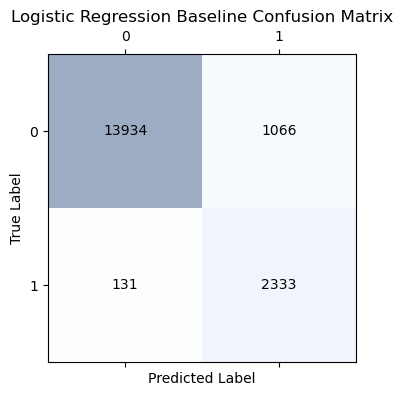

Wall time: 78.8 ms


In [336]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=lr_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Baseline Confusion Matrix')
plt.show()

### Undersampled Data

#### Grid Search Cross Validation for Logistic Regression Undersampled

Perform grid search cross validaiton for the Logistic Regression undersampled dataset to find the best hyper parameters.

In [138]:
%%time

param_C = [0.001, 0.01, 0.1, 1.0]
lr_grid = [{'LR__penalty':['l1', 'l2'],
           'LR__C':param_C}]

pipe_lr_under = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(solver='saga', random_state=1, max_iter=2000))])

lr_grid_cv_under = GridSearchCV(estimator=pipe_lr_under, param_grid=lr_grid, scoring='accuracy', cv=5, n_jobs=-1)

lr_gs_under = lr_grid_cv_under.fit(X_train_under, np.ravel(y_train_under))
print('Logistic Regression Undersampling Best Parameters: {}'.format(lr_gs_under.best_params_))
print('Logistic Regression Undersampling Train Accuracy: {:.6f}'.format(lr_gs_under.best_score_))

Logistic Regression Undersampling Best Parameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Logistic Regression Undersampling Train Accuracy: 0.916768
Wall time: 14.5 s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Find the Test Accuracy, Precision, and Recall for the best undersampled Logistic Regression model

In [139]:
%%time

lr_under_best_clf = lr_gs_under.best_estimator_
lr_under_best_clf.fit(X_train_under, np.ravel(y_train_under))
lr_under_best_pred = lr_under_best_clf.predict(X_test)

print('Logistic Regression Undersampling Test Accuracy: {:.6f}'.format(lr_under_best_clf.score(X_test, y_test)))
print('Logistic Regression Undersampling Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=lr_under_best_pred)))
print('Logistic Regression Undersampling Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=lr_under_best_pred)))

Logistic Regression Undersampling Test Accuracy: 0.926191
Logistic Regression Undersampling Test Precision: 0.678192
Logistic Regression Undersampling Test Recall: 0.907468
Wall time: 3.73 s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### K-Fold Cross Validation for Logistic Regression Undersampled

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Logistic Regression undersampled model

In [156]:
%%time

pipe_under_lr = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=1, max_iter=2000))])

under_scores = cross_val_score(estimator=pipe_under_lr,
                              X=X_train_under,
                              y=np.ravel(y_train_under),
                              cv=10,
                              n_jobs=-1)

print('Undersampled Logistic Regression CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(under_scores), np.std(under_scores)))

Undersampled Logistic Regression CV Accuracy: 0.917 +/- 0.004
Wall time: 7.28 s


#### Learning Curve for Logistic Regression Undersampled

Create a learning curve for the Logistic Regression undersampled model to measure the training and validation accuracies based on the number of training samples.

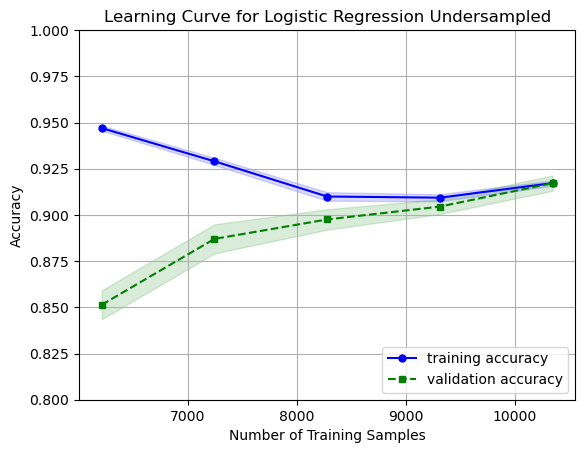

Wall time: 30.2 s


In [155]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_under_lr,
                                                        X=X_train_under,
                                                        y=np.ravel(y_train_under),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Logistic Regression Undersampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show( )

#### Validation Curve for Logistic Regression Undersampled

Create a validation curve for the Logistic Regression undersampled model to measure the accuracy for the training and validation sets for the C hyperparameter. 

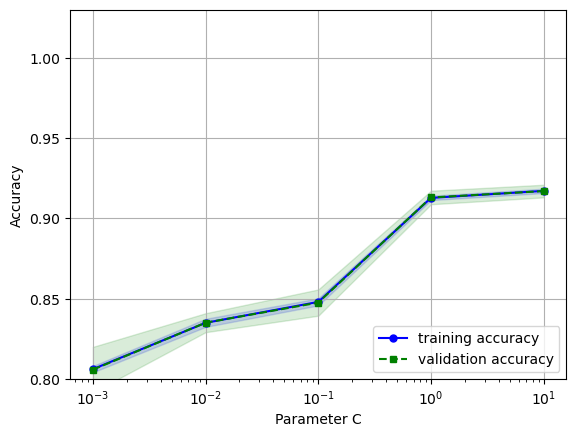

Wall time: 14 s


In [157]:
%%time

param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr_under,
                                            X=X_train_under,
                                            y=np.ravel(y_train_under),
                                            param_name='LR__C',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Logistic Regression Undersampled

Create a confusion matrix which plots the true positive, false positive, true negative, and false negative.

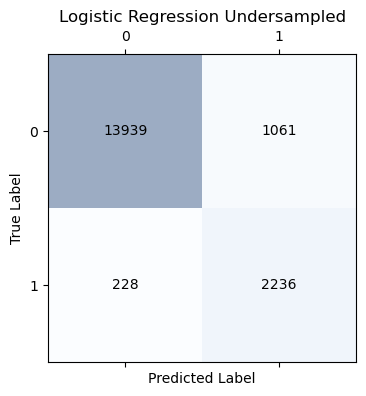

Wall time: 62.4 ms


In [158]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=lr_under_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Undersampled')
plt.show()

### Oversampled Data

#### Grid Search Cross Validation for Logistic Regression Oversampled with Standardization

Perform grid search cross validation for the Logistic Regression oversampled dataset to find the best hyperparameter values for the penalty and C parameters.

In [144]:
%%time

param_C = [0.001, 0.01, 0.1, 1.0]
lr_grid = [{'LR__penalty':['l1', 'l2'],
           'LR__C':param_C}]

pipe_lr_over = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(solver='saga', random_state=1, max_iter=2000))])

lr_grid_cv_over = GridSearchCV(estimator=pipe_lr_over, param_grid=lr_grid, scoring='accuracy', cv=5, n_jobs=-1)

lr_gs_over = lr_grid_cv_over.fit(X_train_over, np.ravel(y_train_over))
print('Logistic Regression Oversampling Best Parameters: {}'.format(lr_gs_over.best_params_))
print('Logistic Regression Oversampling Train Accuracy: {:.6f}'.format(lr_gs_over.best_score_))

Logistic Regression Oversampling Best Parameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Logistic Regression Oversampling Train Accuracy: 0.949387
Wall time: 2min 7s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Find the Test Accuracy, Precision and Recall for the Logistic Regression Oversampled dataset

In [145]:
%%time

lr_over_best_clf = lr_gs_over.best_estimator_
lr_over_best_clf.fit(X_train_over, np.ravel(y_train_over))
lr_over_best_pred = lr_over_best_clf.predict(X_test)

print('Logistic Regression Oversampling Test Accuracy: {:.6f}'.format(lr_over_best_clf.score(X_test, y_test)))
print('Logistic Regression Oversampling Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=lr_over_best_pred)))
print('Logistic Regression Oversampling Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=lr_over_best_pred)))

Logistic Regression Oversampling Test Accuracy: 0.961464
Logistic Regression Oversampling Test Precision: 0.945744
Logistic Regression Oversampling Test Recall: 0.771104
Wall time: 25.5 s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### K-Fold Cross Validation for Logistic Regression Oversampled with Standardization

Perform $k$-fold cross validation to find the best cross-validated accuracy for the Logistic Regression oversampled model.

In [150]:
%%time

pipe_over_lr = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=1, max_iter=2000))])

over_scores = cross_val_score(estimator=pipe_over_lr,
                              X=X_train_over,
                              y=np.ravel(y_train_over),
                              cv=10,
                              n_jobs=-1)

print('Oversampled Logistic Regression CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(over_scores), np.std(over_scores)))

Oversampled Logistic Regression CV Accuracy: 0.950 +/- 0.002
Wall time: 1min 1s


#### Learning Curve for Logistic Regression Oversampled

Create a learning curve for the Logistic Regression oversampled model to measure the training and validation accuracies based on the number of training samples.

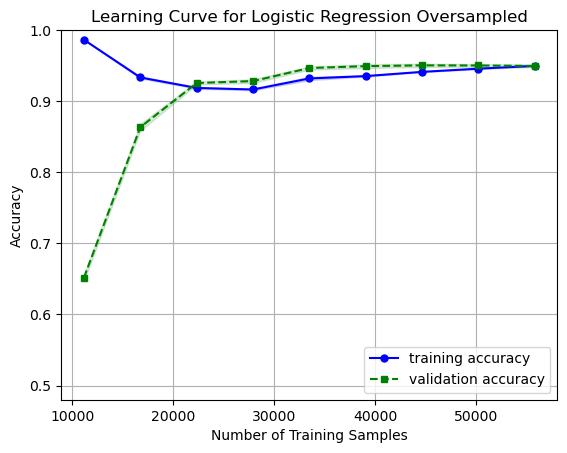

Wall time: 4min 45s


In [306]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_over_lr,
                                                        X=X_train_over,
                                                        y=np.ravel(y_train_over),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Logistic Regression Oversampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.48, 1.0])
plt.show( )

#### Validation Curve for Logistic Regression Oversampled

Create a validation curve for the Logistic Regression oversampled model to measure the accuracy for the training and validation sets for the C hyperparameter.

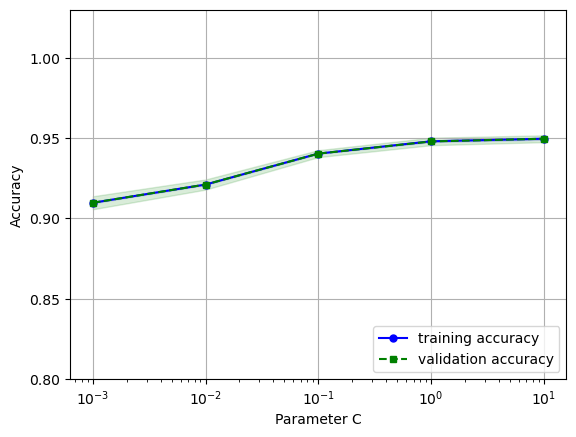

Wall time: 2min 18s


In [160]:
%%time

param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr_over,
                                            X=X_train_over,
                                            y=np.ravel(y_train_over),
                                            param_name='LR__C',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Logistic Regression Oversampled

Create a confusion matrix which plots the true positive, false positive, true negative and false negative.

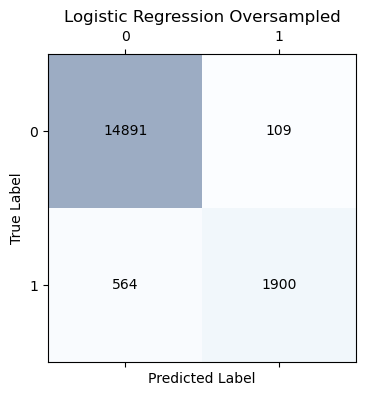

Wall time: 74.1 ms


In [161]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=lr_over_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Oversampled')
plt.show()

### SMOTE Data

#### Grid Search Cross Validation for Logistic Regression SMOTE

Perform grid search cross validation for the Logistic Regression SMOTE dataset to find the best hyperparameters for the penalty and C parameters.

In [209]:
%%time

param_C = [0.001, 0.01, 0.1, 1.0]
lr_grid = [{'LR__penalty':['l1', 'l2'],
           'LR__C':param_C}]

pipe_lr_smote = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(solver='saga', random_state=1, max_iter=2000))])

lr_grid_cv_smote = GridSearchCV(estimator=pipe_lr_smote, param_grid=lr_grid, scoring='accuracy', cv=5, n_jobs=-1)

lr_gs_smote = lr_grid_cv_smote.fit(X_train_smote, np.ravel(y_train_smote))
print('Logistic Regression SMOTE Best Parameters: {}'.format(lr_gs_smote.best_params_))
print('Logistic Regression SMOTE Train Accuracy: {:.6f}'.format(lr_gs_smote.best_score_))

Logistic Regression SMOTE Best Parameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Logistic Regression SMOTE Train Accuracy: 0.939861
Wall time: 1min 41s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Find the Test Accuracy, Precision, and Recall for the best Logistic Regression SMOTE model

In [210]:
%%time

lr_smote_best_clf = lr_gs_smote.best_estimator_
lr_smote_best_clf.fit(X_train_smote, np.ravel(y_train_smote))
lr_smote_best_pred = lr_smote_best_clf.predict(X_test)

print('Logistic Regression SMOTE Test Accuracy: {:.6f}'.format(lr_smote_best_clf.score(X_test, y_test)))
print('Logistic Regression SMOTE Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)))
print('Logistic Regression SMOTE Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)))

Logistic Regression SMOTE Test Accuracy: 0.961063
Logistic Regression SMOTE Test Precision: 0.854531
Logistic Regression SMOTE Test Recall: 0.872565
Wall time: 22.3 s


C:\Users\rewar\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### K-Fold Cross Validation for Logistic Regression SMOTE with Standardization

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Logistic Regression SMOTE model

In [211]:
%%time

pipe_smote_lr = Pipeline([('scl', StandardScaler()),
                         ('LR', LogisticRegression(C=1.0, penalty='l1', solver='saga', max_iter=2000, random_state=1))])

smote_scores = cross_val_score(estimator=pipe_smote_lr,
                              X=X_train_smote,
                              y=np.ravel(y_train_smote),
                              cv=10,
                              n_jobs=-1)

print('SMOTE Logistic Regression CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(smote_scores), np.std(smote_scores)))

SMOTE Logistic Regression CV Accuracy: 0.940 +/- 0.005
Wall time: 46.9 s


#### Learning Curve for Logistic Regression SMOTE

Create a learning curve for the Logistic Regression SMOTE model to measure the training and validation accuracies based on the number of training samples.

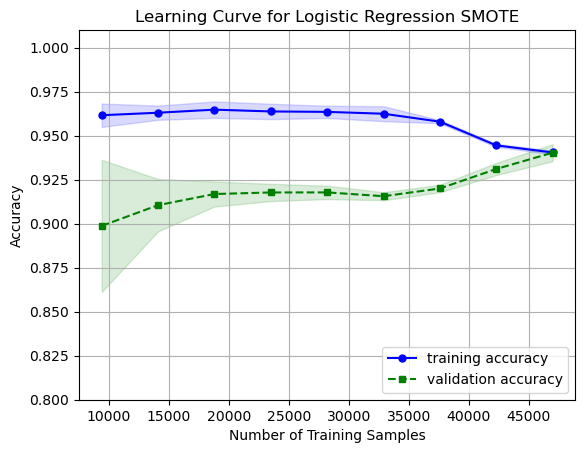

Wall time: 3min 48s


In [305]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_smote_lr,
                                                        X=X_train_smote,
                                                        y=np.ravel(y_train_smote),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Logistic Regression SMOTE', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.show( )

#### Validation Curve for Logistic Regression SMOTE

Create a validation curve for the Logistic Regression SMOTE model to measure the accuracy for the training and validation sets for the C hyperparameter.

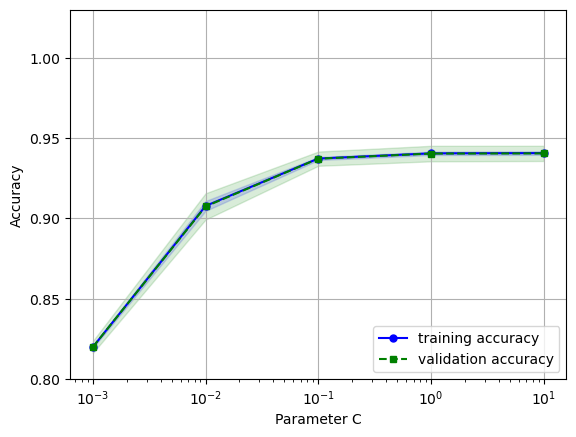

Wall time: 2min 54s


In [213]:
%%time

param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipe_smote_lr,
                                            X=X_train_smote,
                                            y=np.ravel(y_train_smote),
                                            param_name='LR__C',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Logistic Regression SMOTE

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

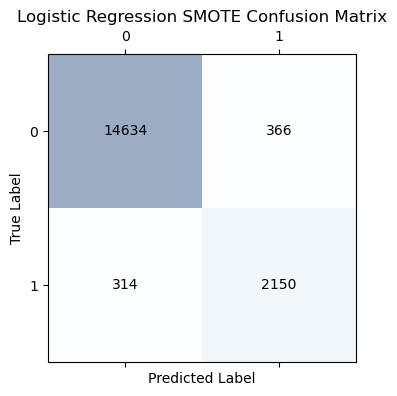

Wall time: 77.7 ms


In [335]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=lr_smote_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression SMOTE Confusion Matrix')
plt.show()

### AUC ROC Curve for Best Logistic Regression Models

Create a plot of the Area Under the Curve Receiver Operator Curve to plot the true positive rate and false positive rate for the best performing model for the Logistic Regression baseline, undersampled, oversampled, and SMOTE models.

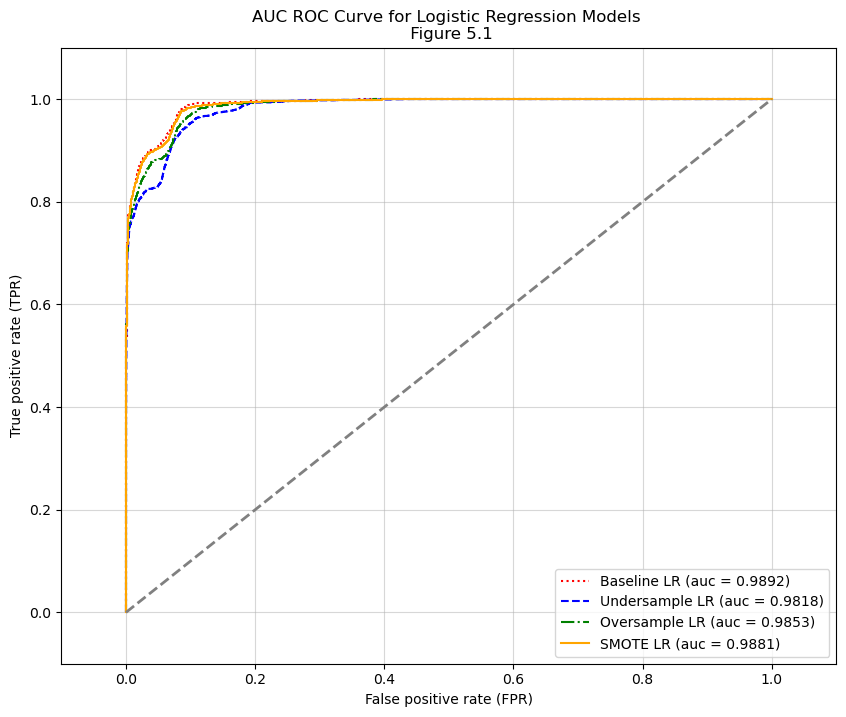

Wall time: 172 ms


In [356]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [lr_best_clf, lr_under_best_clf, lr_over_best_clf, lr_smote_best_clf]
clf_labels = ['Baseline LR', 'Undersample LR', 'Oversample LR', 'SMOTE LR']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.title("AUC ROC Curve for Logistic Regression Models \n Figure 5.1", fontsize="large")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Precision-Recall Curve for Best Logistic Regression Models

Create the Precision-Recall Curve to plot the precision and recall for the best performing model for the Logistic Regression baseline, undersampled, oversampled, and SMOTE models.

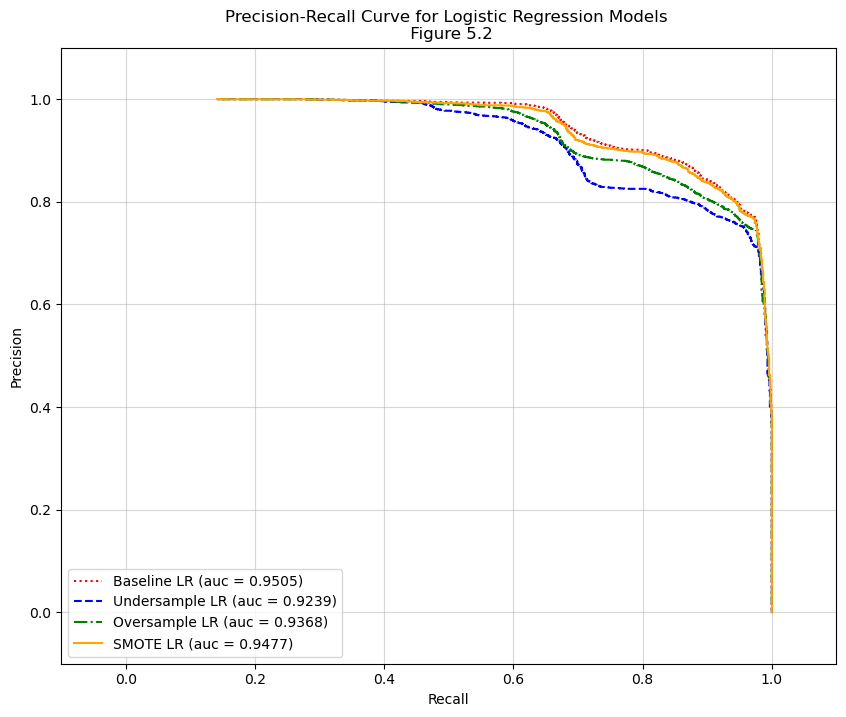

Wall time: 157 ms


In [357]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [lr_best_clf, lr_under_best_clf, lr_over_best_clf, lr_smote_best_clf]
clf_labels = ['Baseline LR', 'Undersample LR', 'Oversample LR', 'SMOTE LR']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(lr_recall, lr_precision)
    plt.plot(lr_precision, lr_recall, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.title("Precision-Recall Curve for Logistic Regression Models \n Figure 5.2", fontsize="large")
plt.legend(loc='lower left')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Table with Logistic Regression Model Results

Create a table of the Logistic Regression baseline, undersampled, oversampled, and SMOTE training and test accuracy scores, test precision, test recall and the best parameters.

In [233]:
%%time

baseline_train_acc = lr_gs.best_score_
baseline_acc = lr_best_clf.score(X_test, y_test)
baseline_cv_acc = '0.919 +/- 0.004'
baseline_cv_time = '1min 6s'
baseline_prec = precision_score(y_true=np.ravel(y_test), y_pred=lr_best_pred)
baseline_recall = recall_score(y_true=np.ravel(y_test), y_pred=lr_best_pred)
baseline_params = lr_gs.best_params_

undersamp_train_acc = lr_gs_under.best_score_
undersamp_acc = lr_under_best_clf.score(X_test, y_test)
undersamp_cv_acc = '0.917 +/- 0.004'
undersamp_cv_time = '7.28 s'
undersamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=lr_under_best_pred)
undersamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=lr_under_best_pred)
undersamp_params = lr_gs_under.best_params_

oversamp_train_acc = lr_gs_over.best_score_
oversamp_acc = lr_over_best_clf.score(X_test, y_test)
oversamp_cv_acc = '0.950 +/- 0.002'
oversamp_cv_time = '1min 1s'
oversamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=lr_over_best_pred)
oversamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=lr_over_best_pred)
oversamp_params = lr_gs_over.best_params_

smote_train_acc = lr_gs_smote.best_score_
smote_acc = lr_smote_best_clf.score(X_test, y_test)
smote_cv_acc = '0.940 +/- 0.005'
smote_cv_time = '46.9 s'
smote_prec = precision_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)
smote_recall = recall_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)
smote_params = lr_gs_smote.best_params_

data = {'Logistic Regression Baseline':[baseline_train_acc, baseline_acc, baseline_cv_acc, baseline_cv_time, baseline_prec, baseline_recall, baseline_params],
       'Logistic Regression Undersampled':[undersamp_train_acc, undersamp_acc, undersamp_cv_acc, undersamp_cv_time, undersamp_prec, undersamp_recall, undersamp_params],
       'Logistic Regression Oversampled':[oversamp_train_acc, oversamp_acc, oversamp_cv_acc, oversamp_cv_time, oversamp_prec, oversamp_recall, oversamp_params],
       'Logistic Regression SMOTE':[smote_train_acc, smote_acc, smote_cv_acc, smote_cv_time, smote_prec, smote_recall, smote_params]}
ind = ['Train Accuracy', 'Test Accuracy', 'Test CV Accuracy', 'CV Wait Time', 'Test Precision', 'Test Recall', 'Best Parameters']
lr_df = pd.DataFrame(data=data, index=ind)
lr_df

Wall time: 45.1 ms


,Logistic Regression Baseline,Logistic Regression Undersampled,Logistic Regression Oversampled,Logistic Regression SMOTE
Train Accuracy,0.922029,0.916768,0.949387,0.939861
Test Accuracy,0.931459,0.926191,0.961464,0.961063
Test CV Accuracy,0.919 +/- 0.004,0.917 +/- 0.004,0.950 +/- 0.002,0.940 +/- 0.005
CV Wait Time,1min 6s,7.28 s,1min 1s,46.9 s
Test Precision,0.686378,0.678192,0.945744,0.854531
Test Recall,0.946834,0.907468,0.771104,0.872565
Best Parameters,"{'LR__C': 1.0, 'LR__penalty': 'l1'}","{'LR__C': 1.0, 'LR__penalty': 'l1'}","{'LR__C': 1.0, 'LR__penalty': 'l1'}","{'LR__C': 1.0, 'LR__penalty': 'l1'}"


In [283]:
lr_df.to_excel("lr_df.xlsx", index=True)

## Random Forests

### Baseline Model

#### Grid Search Cross Validation for Random Forests

Perform grid search cross validation for the Random Forests baseline dataset to find the best hyperparameters for the number of estimators, criterion, and max feature parameters.

In [72]:
%%time

n_estimators = [5, 10, 20, 30, 50]

RF_grid = [{'RF__n_estimators': n_estimators,
            'RF__criterion':['gini', 'entropy'],
            'RF__max_features':['sqrt', 'log2']}]

pipe_RF = Pipeline([('scl', StandardScaler()),
                   ('RF', RandomForestClassifier(random_state=1))])

RF_grid_cv = GridSearchCV(estimator=pipe_RF, param_grid=RF_grid, scoring='accuracy', cv=5, n_jobs=-1)

RF_gs = RF_grid_cv.fit(X_train_mirror, np.ravel(y_train_mirror))
print('Random Forest Baseline Best Parameters: {}'.format(RF_gs.best_params_))
print('Random Forest Baseline Train Accuracy: {:.6f}'.format(RF_gs.best_score_))

Random Forest Baseline Best Parameters: {'RF__criterion': 'entropy', 'RF__max_features': 'sqrt', 'RF__n_estimators': 20}
Random Forest Baseline Train Accuracy: 0.999586
Wall time: 8.81 s


#### Find the Test Accuracy, Precision, and Recall for the best Random Forests Baseline model

In [73]:
%%time

RF_best_clf = RF_gs.best_estimator_
RF_best_clf.fit(X_train, np.ravel(y_train))
RF_best_pred = RF_best_clf.predict(X_test)

print('Random Forest Baseline Test Accuracy: {:.6f}'.format(RF_best_clf.score(X_test, np.ravel(y_test))))
print('Random Forest Baseline Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=RF_best_pred)))
print('Random Forest Baseline Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=RF_best_pred)))

Random Forest Baseline Test Accuracy: 0.992900
Random Forest Baseline Test Precision: 0.973301
Random Forest Baseline Test Recall: 0.976461
Wall time: 481 ms


#### K-Fold Cross Validation for Random Forests

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Random Forests baseline model.

In [170]:
%%time

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('RF', RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=20, random_state=1))])

rf_scores = cross_val_score(estimator=pipe_rf,
                            X=X_train_mirror,
                            y=np.ravel(y_train_mirror),
                            cv=10,
                            n_jobs=-1)

print('Baseline Random Forests CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(rf_scores), np.std(rf_scores)))

Baseline Random Forests CV Accuracy: 1.000 +/- 0.000
Wall time: 1.19 s


#### Learning Curve for Random Forests

Create a learning curve for the Random Forests baseline model to measure the training and validation accuracies based on the number of training samples.

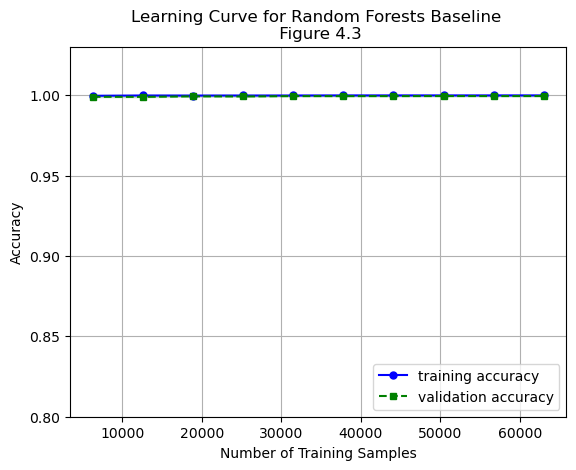

Wall time: 5.27 s


In [310]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf,
                                                        X=X_train_mirror,
                                                        y=np.ravel(y_train_mirror),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Random Forests Baseline \n Figure 4.3', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show( )

#### Validation Curve for Random Forests

Create a validation curve for the Random Forests baseline model to measure the accuracy for the training and validation sets for the number of estimators hyperparameter.

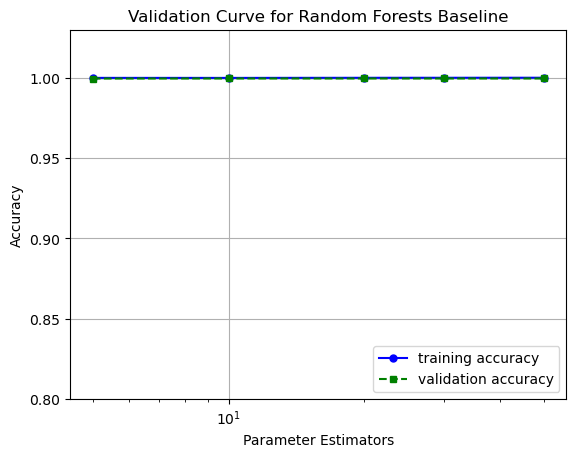

Wall time: 6.34 s


In [173]:
%%time

param_range = [5, 10, 20, 30, 50]
train_scores, test_scores = validation_curve(estimator=pipe_rf,
                                            X=X_train_mirror,
                                            y=np.ravel(y_train_mirror),
                                            param_name='RF__n_estimators',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Random Forests Baseline', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Random Forests with Standardized Data Confusion Matrix

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

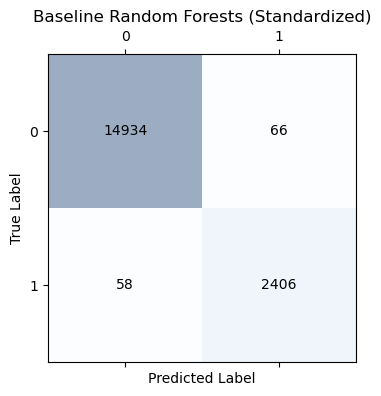

Wall time: 77.6 ms


In [174]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=RF_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Random Forests (Standardized)')
plt.show()

### Undersampled Data

#### Grid Search Cross Validation for Random Forests with Undersampled Data

Perform grid search cross validation for the Random Forests undersampled dataset to find the best hyperparameters for the number of estimators, criterion, and max feature parameters.

In [78]:
%%time

n_estimators = [100, 250, 500, 750, 1000]

RF_grid = [{'RF__n_estimators': n_estimators,
            'RF__criterion':['gini', 'entropy'],
            'RF__max_features':['sqrt', 'log2']}]

pipe_RF_under = Pipeline([('scl', StandardScaler()),
                   ('RF', RandomForestClassifier(random_state=1))])

RF_under_grid_cv = GridSearchCV(estimator=pipe_RF_under, param_grid=RF_grid, scoring='accuracy', cv=5, n_jobs=-1)

RF_gs_under = RF_under_grid_cv.fit(X_train_under, np.ravel(y_train_under))
print('Random Forest Undersampled Best Parameters: {}'.format(RF_gs_under.best_params_))
print('Random Forest Undersampled Train Accuracy: {:.6f}'.format(RF_gs_under.best_score_))

Random Forest Undersampled Best Parameters: {'RF__criterion': 'entropy', 'RF__max_features': 'sqrt', 'RF__n_estimators': 500}
Random Forest Undersampled Train Accuracy: 0.990607
Wall time: 40.3 s


#### Find the Test Accuracy, Precision, and Recall for the best Random Forests Undersampled model

In [79]:
%%time

RF_under_best_clf = RF_gs_under.best_estimator_
RF_under_best_clf.fit(X_train, np.ravel(y_train))
RF_under_best_pred = RF_under_best_clf.predict(X_test)

print('Random Forest Undersampled Test Accuracy: {:.6f}'.format(RF_under_best_clf.score(X_test, np.ravel(y_test))))
print('Random Forest Undersampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=RF_under_best_pred)))
print('Random Forest Undersampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=RF_under_best_pred)))

Random Forest Undersampled Test Accuracy: 0.993415
Random Forest Undersampled Test Precision: 0.972256
Random Forest Undersampled Test Recall: 0.981331
Wall time: 11 s


#### K-Fold Cross Validation for Random Forests with Undersampled Data

Create a learning curve for the Random Forests undersampled model to measure the training and validation accuracies based on the number of training samples.

In [175]:
%%time

pipe_under_rf = Pipeline([('scl', StandardScaler()),
                         ('RF', RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=500))])

rf_under_scores = cross_val_score(estimator=pipe_under_rf,
                              X=X_train_under,
                              y=np.ravel(y_train_under),
                              cv=10,
                              n_jobs=-1)

print('Undersampled Random Forests CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(rf_under_scores), np.std(rf_under_scores)))

Undersampled Random Forests CV Accuracy: 0.991 +/- 0.002
Wall time: 4.68 s


#### Learning Curve for Random Forests with Undersampled Data

Create a learning curve for the Random Forests undersampled model to measure the training and validation accuracies based on the number of training samples.

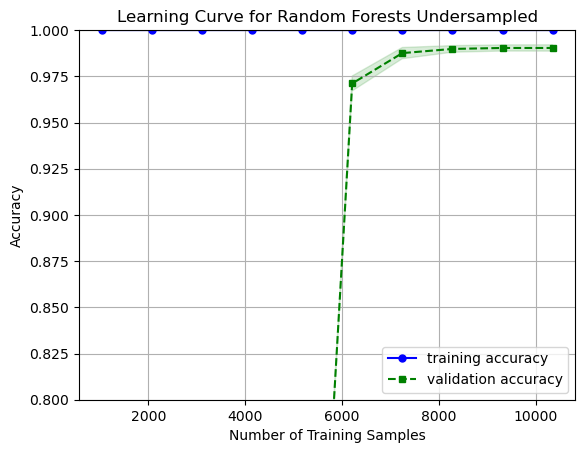

Wall time: 24.3 s


In [176]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_under_rf,
                                                        X=X_train_under,
                                                        y=np.ravel(y_train_under),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Random Forests Undersampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show( )

#### Validation Curve for Random Forests with Undersampled Data

Create a validation curve for the Random Forests undersampled model to measure the accuracy for the training and validation sets for the number of estimators hyperparameter.

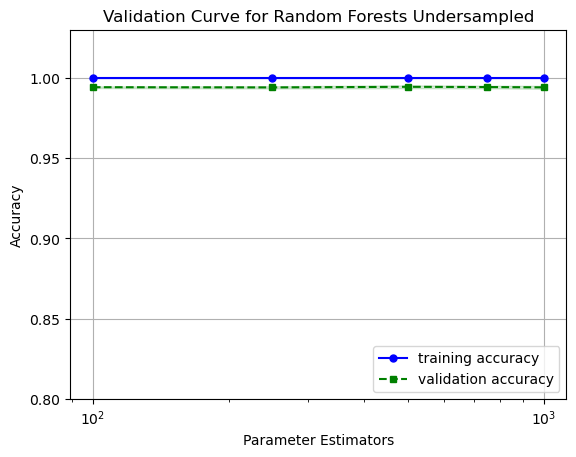

Wall time: 1min 36s


In [177]:
%%time

param_range = [100, 250, 500, 750, 1000]
train_scores, test_scores = validation_curve(estimator=pipe_under_rf,
                                            X=X_train,
                                            y=np.ravel(y_train),
                                            param_name='RF__n_estimators',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Random Forests Undersampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Random Forests Undersampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

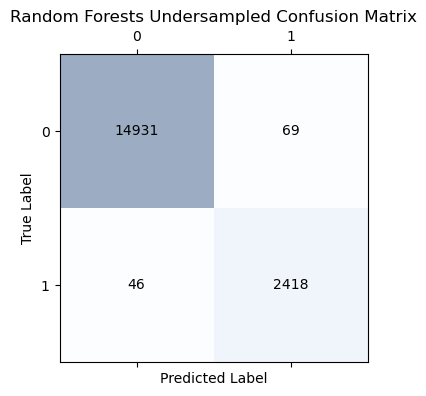

Wall time: 79.3 ms


In [334]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=RF_under_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forests Undersampled Confusion Matrix')
plt.show()

### Oversampled Data

#### Grid Search Cross Validation for Random Forests with Oversampled Data

Perform grid search cross validation for the Random Forests oversampled dataset to find the best hyperparameters for the number of estimators, criterion, and max feature parameters.

In [84]:
%%time

n_estimators = [20, 30, 50, 100, 250, 500]

RF_grid = [{'RF__n_estimators': n_estimators,
            'RF__criterion':['gini', 'entropy'],
            'RF__max_features':['sqrt', 'log2']}]

pipe_RF_over = Pipeline([('scl', StandardScaler()),
                   ('RF', RandomForestClassifier(random_state=1))])

RF_over_grid_cv = GridSearchCV(estimator=pipe_RF_over, param_grid=RF_grid, scoring='accuracy', cv=5, n_jobs=-1)

RF_gs_over = RF_over_grid_cv.fit(X_train_over, np.ravel(y_train_over))
print('Random Forest Oversampled Best Parameters: {}'.format(RF_gs_over.best_params_))
print('Random Forest Oversampled Train Accuracy: {:.6f}'.format(RF_gs_over.best_score_))

Random Forest Oversampled Best Parameters: {'RF__criterion': 'gini', 'RF__max_features': 'sqrt', 'RF__n_estimators': 50}
Random Forest Oversampled Train Accuracy: 0.996194
Wall time: 1min 16s


#### Find the Test Accuracy, Precision, and Recall for the best Random Forests Oversampled model

In [85]:
%%time

RF_over_best_clf = RF_gs_over.best_estimator_
RF_over_best_clf.fit(X_train, np.ravel(y_train))
RF_over_best_pred = RF_over_best_clf.predict(X_test)

print('Random Forest Oversampled Test Accuracy: {:.6f}'.format(RF_over_best_clf.score(X_test, np.ravel(y_test))))
print('Random Forest Oversampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=RF_over_best_pred)))
print('Random Forest Oversampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=RF_over_best_pred)))

Random Forest Oversampled Test Accuracy: 0.993587
Random Forest Oversampled Test Precision: 0.972289
Random Forest Oversampled Test Recall: 0.982549
Wall time: 889 ms


#### K-Fold Cross Validation for Random Forests with Oversampled Data

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Random Forests oversampled model.

In [179]:
%%time

pipe_over_rf = Pipeline([('scl', StandardScaler()),
                         ('RF', RandomForestClassifier(criterion='gini', max_features='sqrt', n_estimators=50, random_state=1))])

rf_over_scores = cross_val_score(estimator=pipe_over_rf,
                              X=X_train_over,
                              y=np.ravel(y_train_over),
                              cv=10,
                              n_jobs=-1)

print('Oversampled Random Forests CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(rf_over_scores), np.std(rf_over_scores)))

Oversampled Random Forests CV Accuracy: 0.996 +/- 0.001
Wall time: 2.13 s


#### Learning Curve for Random Forests with Oversampled Data

Create a learning curve for the Random Forests oversampled model to measure the training and validation accuracies based on the number of training samples.

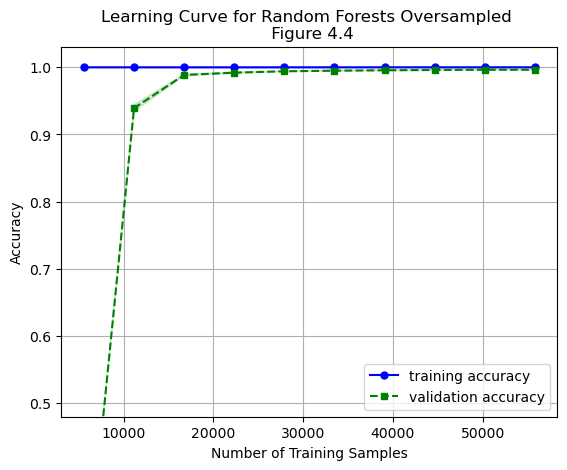

Wall time: 11.3 s


In [312]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_over_rf,
                                                        X=X_train_over,
                                                        y=np.ravel(y_train_over),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Random Forests Oversampled \n Figure 4.4', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.48, 1.03])
plt.show( )

#### Validation Curve for Random Forests with Oversampled Data

Create a validation curve for the Random Forests oversampled model to measure the accuracy for the training and validation sets for the number of estimators hyperparameter.

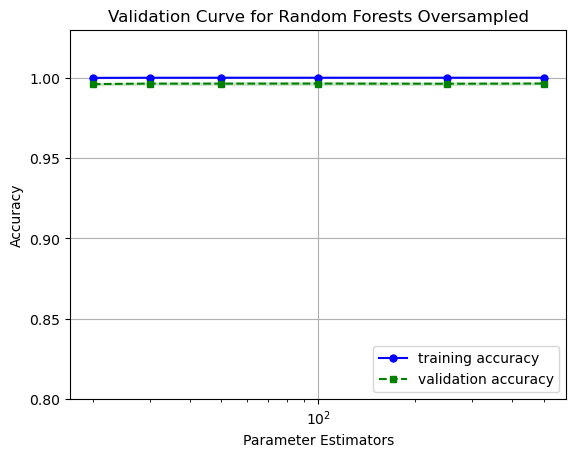

Wall time: 44.8 s


In [181]:
%%time

param_range = [20, 30, 50, 100, 250, 500]
train_scores, test_scores = validation_curve(estimator=pipe_over_rf,
                                            X=X_train_over,
                                            y=np.ravel(y_train_over),
                                            param_name='RF__n_estimators',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Random Forests Oversampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Random Forests Oversampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

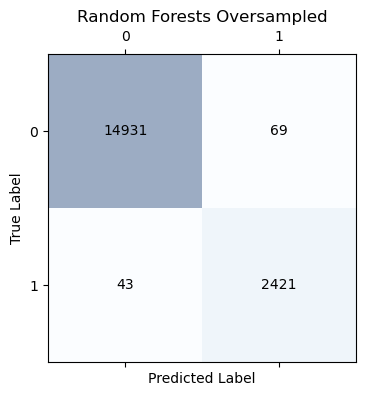

Wall time: 132 ms


In [182]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=RF_over_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forests Oversampled')
plt.show()

### SMOTE Data

#### Grid Search Cross Validation for Random Forests with SMOTE Data

Perform grid search cross validation for the Random Forests SMOTE dataset to find the best hyperparameters for the number of estimators, criterion, and max feature parameters.

In [90]:
%%time

n_estimators = [20, 30, 50, 100, 250, 500]

RF_grid = [{'RF__n_estimators': n_estimators,
            'RF__criterion':['gini', 'entropy'],
            'RF__max_features':['sqrt', 'log2']}]

pipe_RF_smote = Pipeline([('scl', StandardScaler()),
                   ('RF', RandomForestClassifier(random_state=1))])

RF_smote_grid_cv = GridSearchCV(estimator=pipe_RF_smote, param_grid=RF_grid, scoring='accuracy', cv=5, n_jobs=-1)

RF_gs_smote = RF_smote_grid_cv.fit(X_train_smote, np.ravel(y_train_smote))
print('Random Forest SMOTE Best Parameters: {}'.format(RF_gs_smote.best_params_))
print('Random Forest SMOTE Train Accuracy: {:.6f}'.format(RF_gs_smote.best_score_))

Random Forest SMOTE Best Parameters: {'RF__criterion': 'entropy', 'RF__max_features': 'sqrt', 'RF__n_estimators': 250}
Random Forest SMOTE Train Accuracy: 0.995480
Wall time: 1min 15s


#### Find the Test Accuracy, Precision, and Recall for the best Random Forests SMOTE model

In [91]:
%%time

RF_smote_best_clf = RF_gs_smote.best_estimator_
RF_smote_best_clf.fit(X_train, np.ravel(y_train))
RF_smote_best_pred = RF_smote_best_clf.predict(X_test)

print('Random Forest SMOTE Test Accuracy: {:.6f}'.format(RF_smote_best_clf.score(X_test, np.ravel(y_test))))
print('Random Forest SMOTE Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred)))
print('Random Forest SMOTE Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred))) 

Random Forest SMOTE Test Accuracy: 0.993587
Random Forest SMOTE Test Precision: 0.972289
Random Forest SMOTE Test Recall: 0.982549
Wall time: 5.48 s


#### K-Fold Cross Validation for Random Forests with SMOTE Data

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Random Forests SMOTE model.

In [183]:
%%time

pipe_smote_rf = Pipeline([('scl', StandardScaler()),
                         ('RF', RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=250, random_state=1))])

rf_smote_scores = cross_val_score(estimator=pipe_smote_rf,
                              X=X_train_smote,
                              y=np.ravel(y_train_smote),
                              cv=10,
                              n_jobs=-1)

print('SMOTE Random Forests CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(rf_over_scores), np.std(rf_over_scores)))

SMOTE Random Forests CV Accuracy: 0.996 +/- 0.001
Wall time: 11.3 s


#### Learning Curve for Random Forests with SMOTE Data

Create a learning curve for the Random Forests SMOTE model to measure the training and validation accuracies based on the number of training samples.

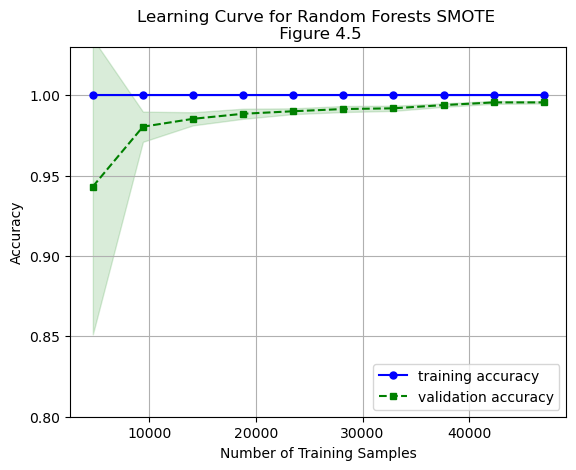

Wall time: 1min 2s


In [314]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_smote_rf,
                                                        X=X_train_smote,
                                                        y=np.ravel(y_train_smote),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Random Forests SMOTE \n Figure 4.5', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show( )

#### Validation Curve for Random Forests with SMOTE Data

Create a validation curve for the Random Forests SMOTE model to measure the accuracy for the training and validation sets for the number of estimators hyperparameter.

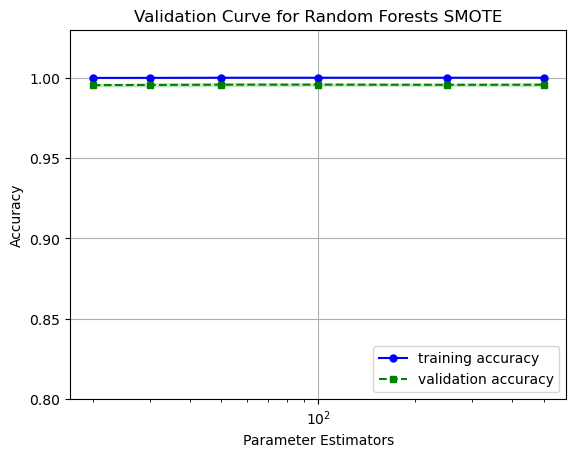

Wall time: 54.7 s


In [185]:
%%time

param_range = [20, 30, 50, 100, 250, 500]
train_scores, test_scores = validation_curve(estimator=pipe_smote_rf,
                                            X=X_train_smote,
                                            y=np.ravel(y_train_smote),
                                            param_name='RF__n_estimators',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Random Forests SMOTE', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Random Forests SMOTE

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

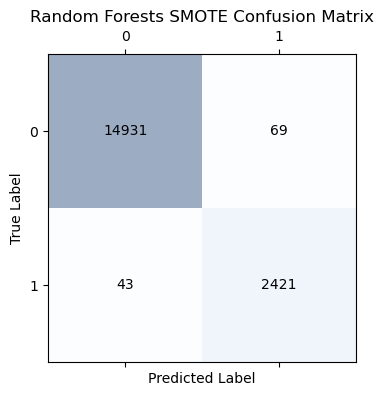

Wall time: 80.4 ms


In [333]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=RF_smote_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forests SMOTE Confusion Matrix')
plt.show()

### AUC ROC Curve for Best Random Forests Models

Create a plot of the Area Under the Curve Receiver Operator Curve to plot the true positive rate and false positive rate for the best performing model for the Random Forests baseline, undersampled, oversampled, and SMOTE models.

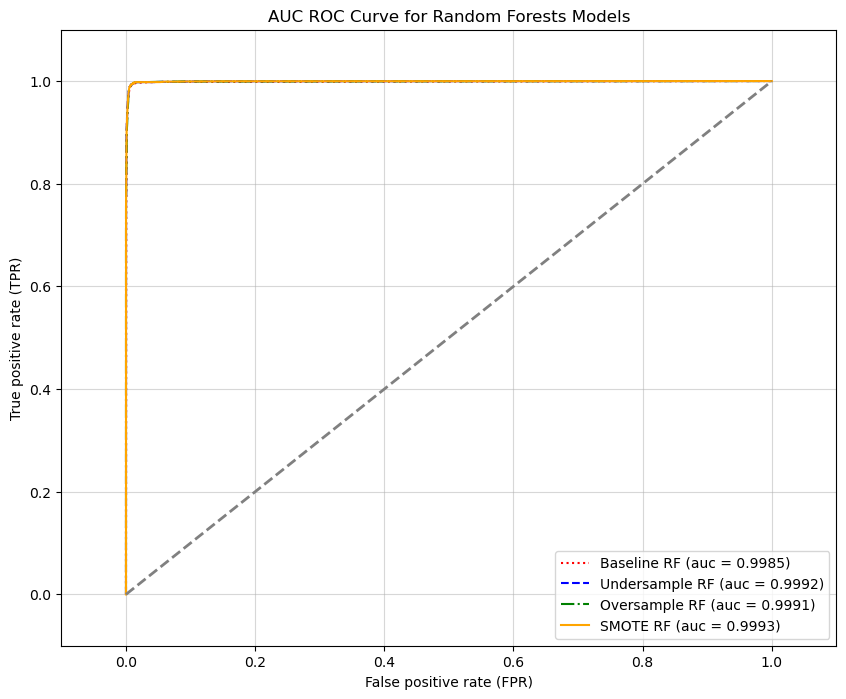

Wall time: 1.13 s


In [332]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [RF_best_clf, RF_under_best_clf, RF_over_best_clf, RF_smote_best_clf]
clf_labels = ['Baseline RF', 'Undersample RF', 'Oversample RF', 'SMOTE RF']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.title("AUC ROC Curve for Random Forests Models", fontsize="large")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Precision-Recall Curve for Best Random Forests Models

Create the Precision-Recall Curve to plot the precision and recall for the best performing Random Forests baseline, undersampled, oversampled, and SMOTE models.

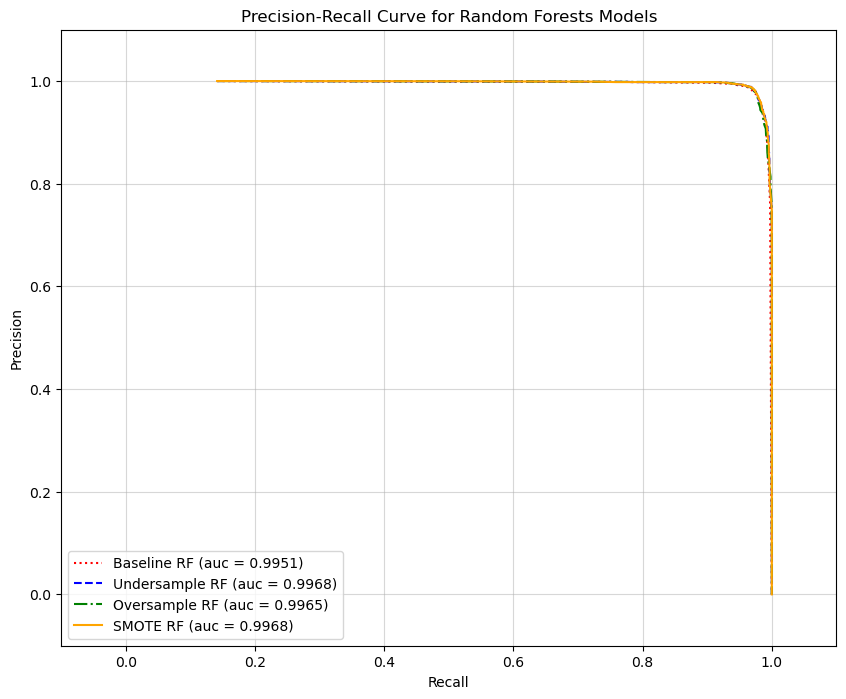

Wall time: 1.17 s


In [331]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [RF_best_clf, RF_under_best_clf, RF_over_best_clf, RF_smote_best_clf]
clf_labels = ['Baseline RF', 'Undersample RF', 'Oversample RF', 'SMOTE RF']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(lr_recall, lr_precision)
    plt.plot(lr_precision, lr_recall, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.title("Precision-Recall Curve for Random Forests Models", fontsize="large")
plt.legend(loc='lower left')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Table with Random Forests Model Results

Create a table of the Random Forests baseline, undersampled, oversampled, and SMOTE training and test accuracy scores, test precision, test recall and the best parameters.

In [239]:
%%time

baseline_train_acc = RF_gs.best_score_
baseline_acc = RF_best_clf.score(X_test, np.ravel(y_test))
baseline_cv_acc = '1.000 +/- 0.000'
baseline_cv_time = '1.19 s'
baseline_prec = precision_score(y_true=np.ravel(y_test), y_pred=RF_best_pred)
baseline_recall = recall_score(y_true=np.ravel(y_test), y_pred=RF_best_pred)
baseline_params = RF_gs.best_params_

undersamp_train_acc = RF_gs_under.best_score_
undersamp_acc = RF_under_best_clf.score(X_test, np.ravel(y_test))
undersamp_cv_acc = '0.991 +/- 0.002'
undersamp_cv_time = '4.68 s'
undersamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=RF_under_best_pred)
undersamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=RF_under_best_pred)
undersamp_params = RF_gs_under.best_params_

oversamp_train_acc = RF_gs_over.best_score_
oversamp_acc = RF_over_best_clf.score(X_test, np.ravel(y_test))
oversamp_cv_acc = '0.996 +/- 0.001'
oversamp_cv_time = '2.13 s'
oversamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=RF_over_best_pred)
oversamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=RF_over_best_pred)
oversamp_params = RF_gs_over.best_params_

smote_train_acc = RF_gs_smote.best_score_
smote_acc = RF_smote_best_clf.score(X_test, np.ravel(y_test))
smote_cv_acc = '0.996 +/- 0.001'
smote_cv_time = '11.3 s'
smote_prec = precision_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred)
smote_recall = recall_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred)
smote_params = RF_gs_smote.best_params_

data = {'Random Forests Baseline':[baseline_train_acc, baseline_acc, baseline_cv_acc, baseline_cv_time, baseline_prec, baseline_recall, baseline_params],
       'Random Forests Undersampled':[undersamp_train_acc, undersamp_acc, undersamp_cv_acc, undersamp_cv_time, undersamp_prec, undersamp_recall, undersamp_params],
       'Random Forests Oversampled':[oversamp_train_acc, oversamp_acc, oversamp_cv_acc, oversamp_cv_time, oversamp_prec, oversamp_recall, oversamp_params],
       'Random Forests SMOTE':[smote_train_acc, smote_acc, smote_cv_acc, smote_cv_time, smote_prec, smote_recall, smote_params]}
ind = ['Train Accuracy', 'Test Accuracy', 'Test CV Accuracy', 'CV Wait Time', 'Test Precision', 'Test Recall', 'Best Parameters']
rf_df = pd.DataFrame(data=data, index=ind)
rf_df

Wall time: 1.02 s


,Random Forests Baseline,Random Forests Undersampled,Random Forests Oversampled,Random Forests SMOTE
Train Accuracy,0.999586,0.990607,0.996194,0.99548
Test Accuracy,0.9929,0.993415,0.993587,0.993587
Test CV Accuracy,1.000 +/- 0.000,0.991 +/- 0.002,0.996 +/- 0.001,0.996 +/- 0.001
CV Wait Time,1.19 s,4.68 s,2.13 s,11.3 s
Test Precision,0.973301,0.972256,0.972289,0.972289
Test Recall,0.976461,0.981331,0.982549,0.982549
Best Parameters,"{'RF__criterion': 'entropy', 'RF__max_features...","{'RF__criterion': 'entropy', 'RF__max_features...","{'RF__criterion': 'gini', 'RF__max_features': ...","{'RF__criterion': 'entropy', 'RF__max_features..."


In [282]:
rf_df.to_excel("rf_df.xlsx", index=True)

## Support Vector Machines

### Baseline Model

#### Grid Search Cross Validation for Support Vector Machines

Perform grid search cross validation for the Support Vector Machines baseline dataset to find the best hyperparameters for the gamma and C parameters.

In [100]:
%%time

gamma = [0.1, 1.0, 10.0, 100.0, 1000.0]
param_C = [10.0, 100.0, 1000.0, 10000.0, 20000.0]

svc_grid = [{'SVM__C': param_C,
            'SVM__gamma':gamma}]

pipe_svc = Pipeline([('scl', StandardScaler()),
                   ('SVM', SVC(probability=True, random_state=1))])

svc_grid_cv = GridSearchCV(estimator=pipe_svc, param_grid=svc_grid, scoring='accuracy', cv=5, n_jobs=-1)

svc_gs = svc_grid_cv.fit(X_train_mirror, np.ravel(y_train_mirror))
print('Support Vector Machines Baseline Best Parameters: {}'.format(svc_gs.best_params_))
print('Support Vector Machines Baseline Train Accuracy: {:.6f}'.format(svc_gs.best_score_))

Support Vector Machines Baseline Best Parameters: {'SVM__C': 20000.0, 'SVM__gamma': 0.1}
Support Vector Machines Baseline Train Accuracy: 0.999457
Wall time: 1h 24min 14s


#### Find the Test Accuracy, Precision, and Recall for the best Support Vector Machines baseline model

In [101]:
%%time

svc_best_clf = svc_gs.best_estimator_
svc_best_clf.fit(X_train, np.ravel(y_train))
svc_best_pred = svc_best_clf.predict(X_test)

print('Support Vector Machines Test Accuracy: {:.6f}'.format(svc_best_clf.score(X_test, np.ravel(y_test))))
print('Support Vector Machines Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=svc_best_pred)))
print('Support Vector Machines Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=svc_best_pred))) 

Support Vector Machines Test Accuracy: 0.991583
Support Vector Machines Test Precision: 0.958086
Support Vector Machines Test Recall: 0.983360
Wall time: 57.8 s


#### K-Fold Cross Validation for Support Vector Machines

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Support Vector Machine baseline model.

In [191]:
%%time

pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('SVM', SVC(C=20000.0 ,gamma=0.1, random_state=1))])

svc_scores = cross_val_score(estimator=pipe_svc,
                            X=X_train_mirror,
                            y=np.ravel(y_train_mirror),
                            cv=10,
                            n_jobs=-1)

print('Support Vector Machines Baseline CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(svc_scores), np.std(svc_scores)))

Support Vector Machines Baseline CV Accuracy: 0.999 +/- 0.000
Wall time: 2.87 s


#### Learning Curve for Support Vector Machines

Create a learning curve for the Support Vector Machines baseline model to measure the training and validation accuracies based on the number of training samples.

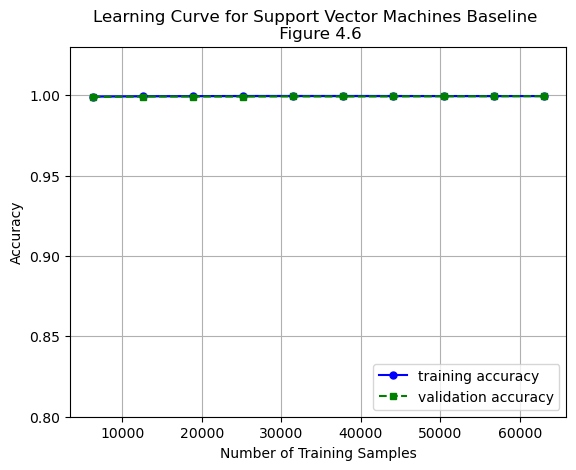

Wall time: 18.2 s


In [320]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc,
                                                        X=X_train_mirror,
                                                        y=np.ravel(y_train_mirror),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Support Vector Machines Baseline \n Figure 4.6', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show( )

#### Validation Curve for Support Vector Machines

Create a validation curve for the Support Vector Machines baseline model to measure the accuracy for the training and validation sets for the gamma hyperparameter.

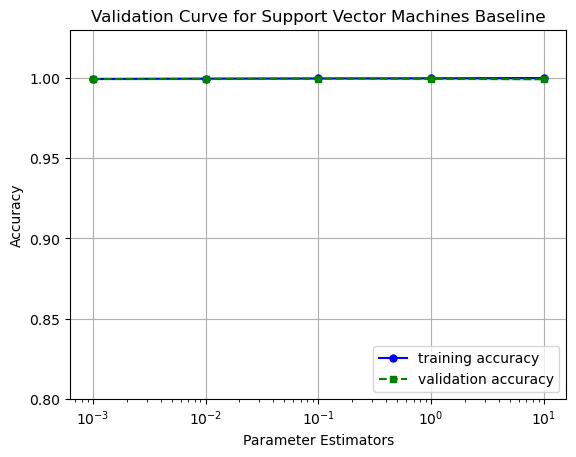

Wall time: 17.2 s


In [193]:
%%time

param_range = [0.001, 0.01, 0.1, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipe_svc,
                                            X=X_train_mirror,
                                            y=np.ravel(y_train_mirror),
                                            param_name='SVM__gamma',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Support Vector Machines Baseline', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Support Vector Machines with Standardized Data Confusion Matrix

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

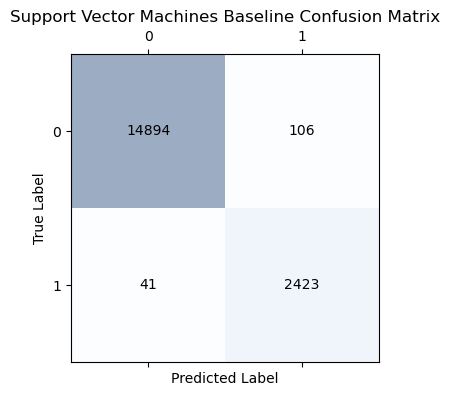

Wall time: 80 ms


In [325]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=svc_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machines Baseline Confusion Matrix')
plt.show()

### Undersampled Data

#### Grid Search Cross Validation for Support Vector Machines with Undersampled Data

Perform grid search cross validation for the Support Vector Machines undersampled dataset to find the best hyperparameters for the gamma and C parameters.

In [106]:
%%time

gamma = [0.1, 1.0, 10.0, 100.0, 1000.0]
param_C = [1000.0, 10000.0, 20000.0, 30000.0, 40000.0]

svc_grid = [{'SVM__C': param_C,
            'SVM__gamma':gamma}]

pipe_SVC = Pipeline([('scl', StandardScaler()),
                    ('SVM', SVC(probability=True, random_state=1))])

SVC_grid_cv_under = GridSearchCV(estimator=pipe_SVC, param_grid=svc_grid, scoring='accuracy', cv=5, n_jobs=-1)

SVC_gs_under = SVC_grid_cv_under.fit(X_train_under, np.ravel(y_train_under))
print('Support Vector Undersampled Best Parameters: {}'.format(SVC_gs_under.best_params_))
print('Support Vector Undersampled Train Accuracy: {:.6f}'.format(SVC_gs_under.best_score_))

Support Vector Undersampled Best Parameters: {'SVM__C': 40000.0, 'SVM__gamma': 0.1}
Support Vector Undersampled Train Accuracy: 0.985128
Wall time: 18min 5s


#### Find the Test Accuracy, Precision, and Recall for the best Support Vector Machines undersampled model

In [107]:
%%time

SVC_under_best_clf = SVC_gs_under.best_estimator_
SVC_under_best_clf.fit(X_train, np.ravel(y_train))
SVC_under_best_pred = SVC_under_best_clf.predict(X_test)

print('Support Vector Undersampled Test Accuracy: {:.6f}'.format(SVC_under_best_clf.score(X_test, np.ravel(y_test))))
print('Support Vector Undersampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)))
print('Support Vector Undersampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)))

Support Vector Undersampled Test Accuracy: 0.992213
Support Vector Undersampled Test Precision: 0.957907
Support Vector Undersampled Test Recall: 0.988231
Wall time: 1min 12s


#### K-Fold Cross Validation for Support Vector Machines with Undersampled Data

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Support Vector Machines undersampled model.

In [195]:
%%time

pipe_under_svc = Pipeline([('scl', StandardScaler()),
                         ('SVM', SVC(gamma=0.1, C=40000.0, random_state=1))])

svc_under_scores = cross_val_score(estimator=pipe_under_svc,
                              X=X_train_under,
                              y=np.ravel(y_train_under),
                              cv=10,
                              n_jobs=-1)
print('Support Vector Machines Undersampled CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(svc_under_scores), np.std(svc_under_scores)))

Support Vector Machines Undersampled CV Accuracy: 0.985 +/- 0.002
Wall time: 8.73 s


#### Learning Curve for Support Vector Machines with Undersampled Data

Create a learning curve for the Support Vector Machines undersampled model to measure the training and validation accuracies based on the number of training samples.

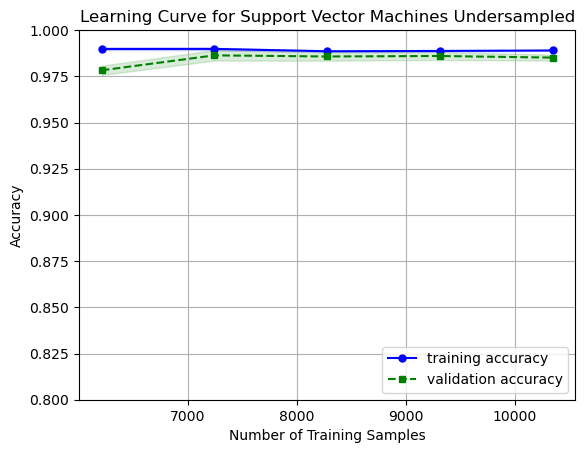

Wall time: 24 s


In [196]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_under_svc,
                                                        X=X_train_under,
                                                        y=np.ravel(y_train_under),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Support Vector Machines Undersampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show( )

#### Validation Curve for Support Vector Machines with Undersampled Data

Create a validation curve for the Support Vector Machines undersampled model to measure the accuracy for the training and validation sets for the gamma hyperparameter.

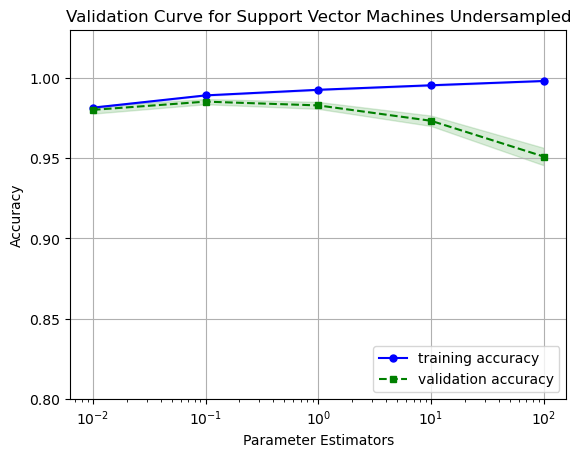

Wall time: 3min 35s


In [197]:
%%time

param_range = [0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_under_svc,
                                            X=X_train_under,
                                            y=np.ravel(y_train_under),
                                            param_name='SVM__gamma',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Support Vector Machines Undersampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Support Vector Machines Undersampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

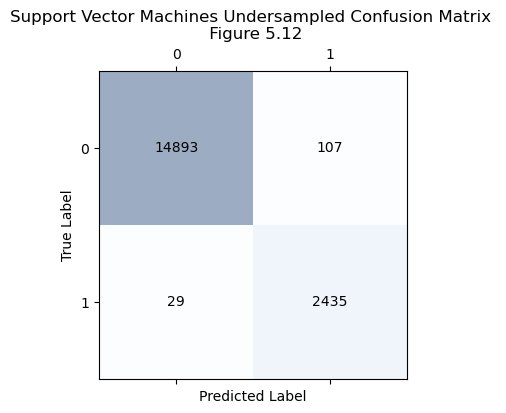

Wall time: 84 ms


In [327]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=SVC_under_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machines Undersampled Confusion Matrix \n Figure 5.12')
plt.show()

### Oversampled Data

#### Grid Search Cross Validation for Support Vector Machines with Oversampled Data

Perform grid search cross validation for the Support Vector Machines oversampled dataset to find the best hyperparameters for the gamma parameter.  Due to computational limitations, the Support Vector Machines Algorithm looped when more than one hyperparameter was passed into grid search cross validation.

In [362]:
%%time

gamma = [0.1, 1.0, 10.0, 100.0]
param_C = [10.0, 100.0, 1000.0, 10000.0]

svc_grid = [{'SVM__gamma': gamma,
            'SVM__C':param_C}]

pipe_SVC = Pipeline([('scl', StandardScaler()),
                    ('SVM', SVC(probability=True, random_state=1))])

SVC_grid_cv_over = GridSearchCV(estimator=pipe_SVC, param_grid=svc_grid, scoring='accuracy', cv=5, n_jobs=-1)

SVC_gs_over = SVC_grid_cv_over.fit(X_train_over, np.ravel(y_train_over))
print('Support Vector Oversampled Best Parameters: {}'.format(SVC_gs_over.best_params_))
print('Support Vector Oversampled Train Accuracy: {:.6f}'.format(SVC_gs_over.best_score_))

Support Vector Oversampled Best Parameters: {'SVM__C': 10000.0, 'SVM__gamma': 10.0}
Support Vector Oversampled Train Accuracy: 0.994113
Wall time: 3h 25min 34s


#### Find the Test Accuracy, Precision, and Recall for the best Support Vector Machines oversampled model

In [363]:
%%time

SVC_over_best_clf = SVC_gs_over.best_estimator_
SVC_over_best_clf.fit(X_train, np.ravel(y_train))
SVC_over_best_pred = SVC_over_best_clf.predict(X_test)

print('Support Vector Oversampled Test Accuracy: {:.6f}'.format(SVC_over_best_clf.score(X_test, np.array(y_test))))
print('Support Vector Oversampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=SVC_over_best_pred)))
print('Support Vector Oversampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=SVC_over_best_pred))) 

Support Vector Oversampled Test Accuracy: 0.991067
Support Vector Oversampled Test Precision: 0.959761
Support Vector Oversampled Test Recall: 0.977679
Wall time: 16min 43s


#### K-Fold Cross Validation for Support Vector Machines with Oversampled Data

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Support Vector Machines oversampled model.

In [364]:
%%time

pipe_over_svc = Pipeline([('scl', StandardScaler()),
                         ('SVM', SVC(C=10000.0, gamma=10.0, random_state=1))])

svc_over_scores = cross_val_score(estimator=pipe_over_svc,
                              X=X_train_over,
                              y=np.ravel(y_train_over),
                              cv=10,
                              n_jobs=-1)

print('Support Vector Machines Oversampled CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(svc_over_scores), np.std(svc_over_scores)))

Support Vector Machines Oversampled CV Accuracy: 0.995 +/- 0.001
Wall time: 12min 49s


#### Learning Curve for Support Vector Machines with Oversampled Data

Create a learning curve for the Support Vector Machines oversampled model to measure the training and validation accuracies based on the number of training samples.

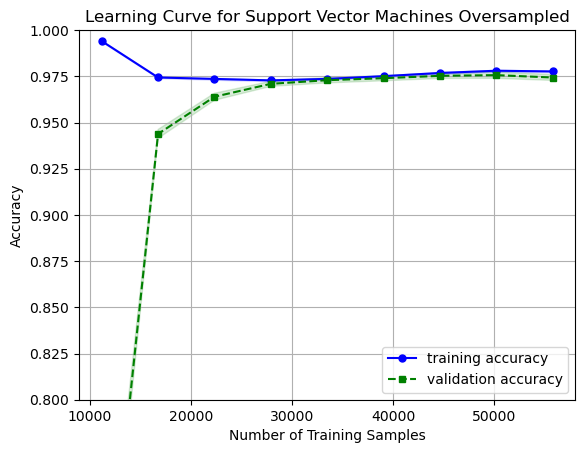

Wall time: 38min 10s


In [200]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_over_svc,
                                                        X=X_train_over,
                                                        y=np.ravel(y_train_over),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Support Vector Machines Oversampled \n ', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show( )

#### Validation Curve for Support Vector Machines with Oversampled Data

Create a validation curve for the Support Vector Machines oversampled model to measure the accuracy for the training and validation sets for the gamma hyperparameter.

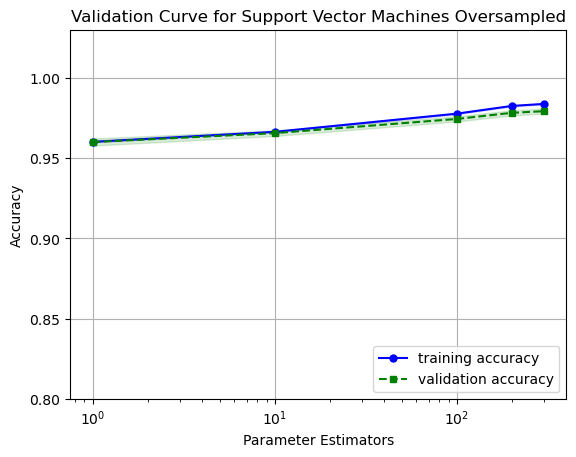

Wall time: 42min 21s


In [201]:
%%time

param_range = [1.0, 10.0, 100.0, 200.0, 300.0]
train_scores, test_scores = validation_curve(estimator=pipe_over_svc,
                                            X=X_train_over,
                                            y=np.ravel(y_train_over),
                                            param_name='SVM__gamma',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Support Vector Machines Oversampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Support Vector Machines Oversampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

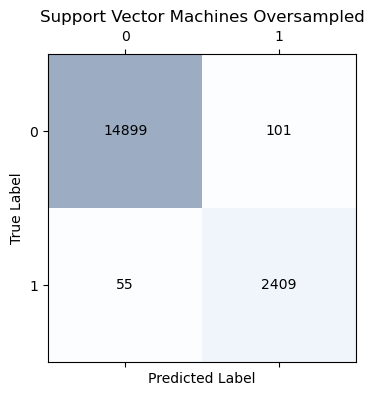

Wall time: 82 ms


In [365]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=SVC_over_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machines Oversampled')
plt.show()

### SMOTE Data

#### Grid Search Cross Validation for Support Vector Machines with SMOTE Data

Perform grid search cross validation for the Support Vector Machines SMOTE dataset to find the best hyperparameters for the 

In [244]:
%%time

gamma = [0.1, 1.0, 10.0, 100.0]
param_C = [10.0, 100.0, 1000.0, 10000.0]

svc_grid = [{'SVM__C': param_C,
            'SVM__gamma':gamma}]

pipe_SVC = Pipeline([('scl', StandardScaler()),
                    ('SVM', SVC(probability=True, random_state=1))])

SVC_grid_cv_smote = GridSearchCV(estimator=pipe_SVC, param_grid=svc_grid, scoring='accuracy', cv=5, n_jobs=-1)

SVC_gs_smote = SVC_grid_cv_smote.fit(X_train_smote, np.ravel(y_train_smote))
print('Support Vector SMOTE Best Parameters: {}'.format(SVC_gs_smote.best_params_))
print('Support Vector SMOTE Train Accuracy: {:.6f}'.format(SVC_gs_smote.best_score_))

Support Vector SMOTE Best Parameters: {'SVM__C': 10000.0, 'SVM__gamma': 10.0}
Support Vector SMOTE Train Accuracy: 0.994005
Wall time: 2h 52min 52s


#### Find the Test Accuracy, Precision, and Recall for the best Support Vector Machines SMOTE model

In [245]:
%%time

SVC_smote_best_clf = SVC_gs_smote.best_estimator_
SVC_smote_best_clf.fit(X_train, np.ravel(y_train))
SVC_smote_best_pred = SVC_smote_best_clf.predict(X_test)

print('Support Vector Oversampled Test Accuracy: {:.6f}'.format(SVC_smote_best_clf.score(X_test, np.ravel(y_test))))
print('Support Vector Oversampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=SVC_smote_best_pred)))
print('Support Vector Oversampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=SVC_smote_best_pred)))  

Support Vector Oversampled Test Accuracy: 0.991067
Support Vector Oversampled Test Precision: 0.959761
Support Vector Oversampled Test Recall: 0.977679
Wall time: 16min 17s


#### K-Fold Cross Validation for Support Vector Machines with SMOTE Data

Perform $k$-fold cross validation to find the best cross-validation accuracy for the Support Vector Machines SMOTE model.

In [203]:
%%time

pipe_smote_svc = Pipeline([('scl', StandardScaler()),
                         ('SVM', SVC(gamma=10.0, C=10000.0, random_state=1))])

svc_smote_scores = cross_val_score(estimator=pipe_smote_svc,
                              X=X_train_smote,
                              y=np.ravel(y_train_smote),
                              cv=10,
                              n_jobs=-1)

print('Support Vector Machines SMOTE CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(svc_smote_scores), np.std(svc_smote_scores)))

Support Vector Machines SMOTE CV Accuracy: 0.994 +/- 0.002
Wall time: 16min 2s


#### Learning Curve for Support Vector Machines with SMOTE Data

Create a learning curve for the Support Vector Machines SMOTE model to measure the training and validation accuracies based on the number of training samples.

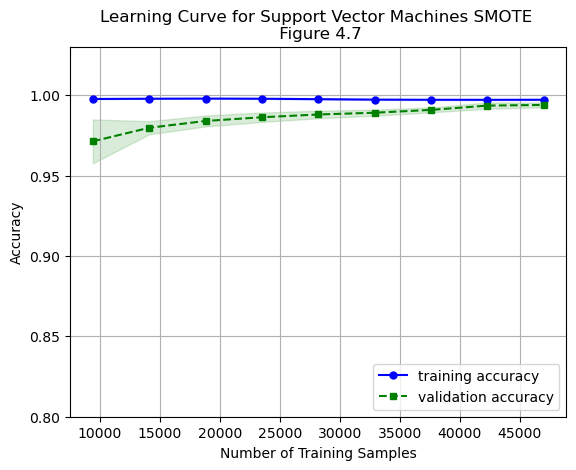

Wall time: 47min 4s


In [321]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_smote_svc,
                                                        X=X_train_smote,
                                                        y=np.ravel(y_train_smote),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Support Vector Machines SMOTE \n Figure 4.7', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show( )

#### Validation Curve for Support Vector Machines with SMOTE Data

Create a validation curve for the Support Vector Machines SMOTE model to measure the accuracy for the training and validation sets for the gamma hyperparameter.

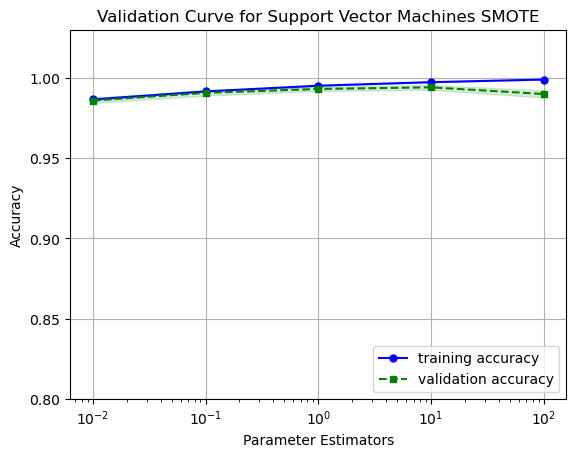

Wall time: 39min 15s


In [205]:
%%time

param_range = [0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_smote_svc,
                                            X=X_train_smote,
                                            y=np.ravel(y_train_smote),
                                            param_name='SVM__gamma',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Support Vector Machines SMOTE', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Confusion Matrix for Support Vector Machines SMOTE

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

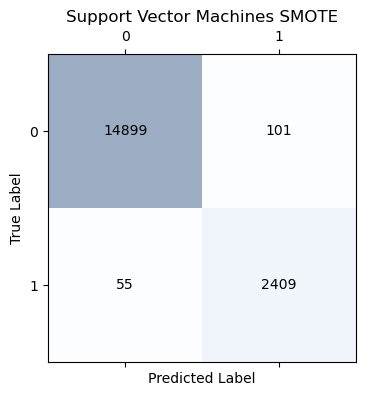

Wall time: 69 ms


In [246]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=SVC_smote_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machines SMOTE')
plt.show()

### AUC ROC Curve for Best Support Vector Machines Models

Create a plot of the Area Under the Curve Receiver Operator Curve to plot the true positive rate and false positive rate for the best performing model for the Support Vector Machines baseline, undersampled, oversampled, and SMOTE models.

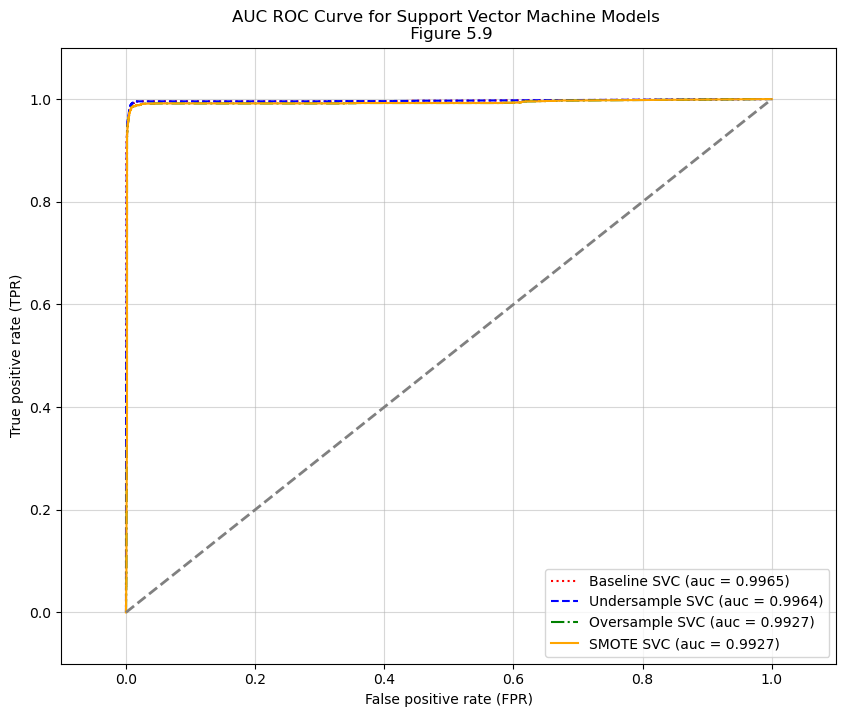

Wall time: 12.7 s


In [372]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [svc_best_clf, SVC_under_best_clf, SVC_over_best_clf, SVC_smote_best_clf]
clf_labels = ['Baseline SVC', 'Undersample SVC', 'Oversample SVC', 'SMOTE SVC']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.title("AUC ROC Curve for Support Vector Machine Models \n Figure 5.9", fontsize="large")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Precision-Recall Curve for Best Support Vector Machines Models

Create the Precision-Recall Curve to plot the precision and recall for the best performing Support Vector Machines baseline, undersampled, oversampled, and SMOTE models.

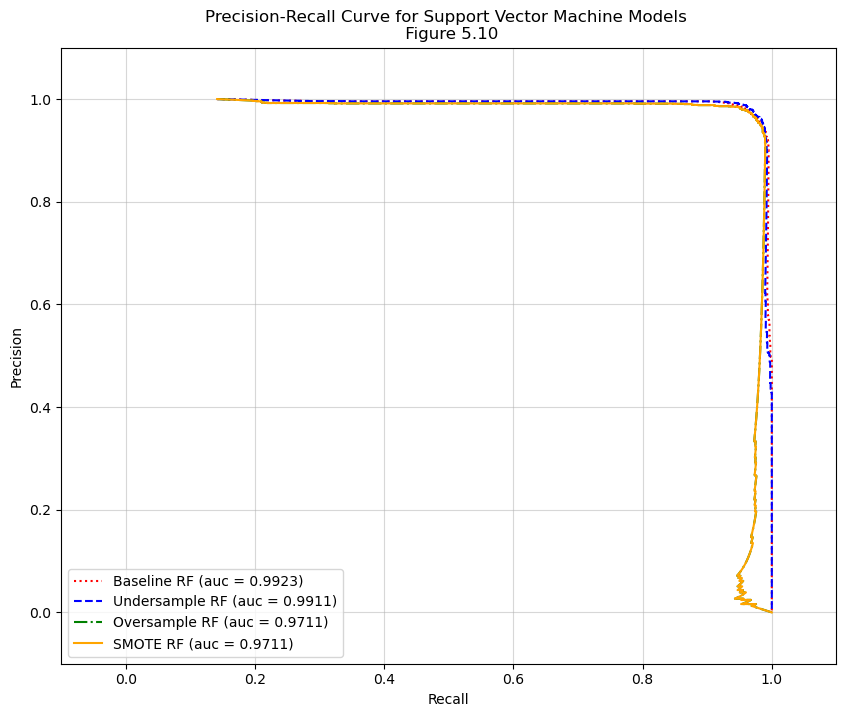

Wall time: 13 s


In [371]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [svc_best_clf, SVC_under_best_clf, SVC_over_best_clf, SVC_smote_best_clf]
clf_labels = ['Baseline RF', 'Undersample RF', 'Oversample RF', 'SMOTE RF']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(lr_recall, lr_precision)
    plt.plot(lr_precision, lr_recall, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.title("Precision-Recall Curve for Support Vector Machine Models \n Figure 5.10", fontsize="large")
plt.legend(loc='lower left')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Table with Support Vector Model Results

Create a table of the Support Vector Machines baseline, undersampled, oversampled, and SMOTE training and test accuracy scores, test precision, test recall and the best parameters.

In [368]:
%%time

baseline_train_acc = svc_gs.best_score_
baseline_acc = svc_best_clf.score(X_test, np.ravel(y_test))
baseline_cv_acc = '0.999 +/- 0.000'
baseline_cv_time = '2.87 s'
baseline_prec = precision_score(y_true=np.ravel(y_test), y_pred=svc_best_pred)
baseline_recall = recall_score(y_true=np.ravel(y_test), y_pred=svc_best_pred)
baseline_params = svc_gs.best_params_

undersamp_train_acc = SVC_gs_under.best_score_
undersamp_acc = SVC_under_best_clf.score(X_test, np.ravel(y_test))
undersamp_cv_acc = '0.985 +/- 0.002'
unsersamp_cv_time = '8.73 s'
undersamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)
undersamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)
undersamp_params = SVC_gs_under.best_params_

oversamp_train_acc = SVC_gs_over.best_score_
oversamp_acc = SVC_over_best_clf.score(X_test, np.array(y_test))
oversamp_cv_acc = '0.995 +/- 0.001'
oversamp_cv_time = '12min 49s'
oversamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=SVC_over_best_pred)
oversamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=SVC_over_best_pred)
oversamp_params = SVC_gs_over.best_params_

smote_train_acc = SVC_gs_smote.best_score_
smote_acc = SVC_smote_best_clf.score(X_test, np.ravel(y_test))
smote_cv_acc = '0.994 +/- 0.002'
smote_cv_time = '16min 2s'
smote_prec = precision_score(y_true=np.ravel(y_test), y_pred=SVC_smote_best_pred)
smote_recall = recall_score(y_true=np.ravel(y_test), y_pred=SVC_smote_best_pred)
smote_params = SVC_gs_smote.best_params_

data = {'SVM Baseline':[baseline_train_acc, baseline_acc, baseline_cv_acc, baseline_cv_time, baseline_prec, baseline_recall, baseline_params],
       'SVM Undersampled':[undersamp_train_acc, undersamp_acc, undersamp_cv_acc, unsersamp_cv_time, undersamp_prec, undersamp_recall, undersamp_params],
       'SVM Oversampled':[oversamp_train_acc, oversamp_acc, oversamp_cv_acc, oversamp_cv_time, oversamp_prec, oversamp_recall, oversamp_params],
       'SVM SMOTE':[smote_train_acc, smote_acc, smote_cv_acc, smote_cv_time, smote_prec, smote_recall, smote_params]}
ind = ['Train Accuracy', 'Test Accuracy', 'Test CV Accuracy', 'CV Wait Time', 'Test Precision', 'Test Recall', 'Best Parameters']
svm_df = pd.DataFrame(data=data, index=ind)
svm_df

Wall time: 12.7 s


,SVM Baseline,SVM Undersampled,SVM Oversampled,SVM SMOTE
Train Accuracy,0.999457,0.985128,0.994113,0.994005
Test Accuracy,0.991583,0.992213,0.991067,0.991067
Test CV Accuracy,0.999 +/- 0.000,0.985 +/- 0.002,0.995 +/- 0.001,0.994 +/- 0.002
CV Wait Time,2.87 s,8.73 s,12min 49s,16min 2s
Test Precision,0.958086,0.957907,0.959761,0.959761
Test Recall,0.98336,0.988231,0.977679,0.977679
Best Parameters,"{'SVM__C': 20000.0, 'SVM__gamma': 0.1}","{'SVM__C': 40000.0, 'SVM__gamma': 0.1}","{'SVM__C': 10000.0, 'SVM__gamma': 10.0}","{'SVM__C': 10000.0, 'SVM__gamma': 10.0}"


In [370]:
svm_df.to_excel("svm_df.xlsx", index=True)

## Naive Bayes Classifier

### Baseline Model

#### Grid Search Cross Validation for Naive Bayes Classifier

Perform grid search cross validation for the Naive Bayes Classifier baseline dataset to find the best hyperparameters for the alpha parameter.

In [217]:
%%time

alpha = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

bnb_grid = [{'BNB__alpha': alpha}]

pipe_bnb = Pipeline([('scl', StandardScaler()),
                    ('BNB', BernoulliNB())])

bnb_grid_cv = GridSearchCV(estimator=pipe_bnb, param_grid=bnb_grid, scoring='accuracy', cv=5, n_jobs=-1)

bnb_gs = bnb_grid_cv.fit(X_train, np.ravel(y_train))
print('Naive Bayes Baseline Best Parameters: {}'.format(bnb_gs.best_params_))
print('Naive Bayes Baseline Train Accuracy: {:.6f}'.format(bnb_gs.best_score_))

Naive Bayes Baseline Best Parameters: {'BNB__alpha': 1e-09}
Naive Bayes Baseline Train Accuracy: 0.862083
Wall time: 329 ms


#### Find the Test Accuracy, Precision, and Recall for the best Naive Bayes Classifier baseline model

In [218]:
%%time

bnb_best_clf = bnb_gs.best_estimator_
bnb_best_clf.fit(X_train, np.ravel(y_train))
bnb_best_pred = bnb_best_clf.predict(X_test)

print('Naive Bayes Baseline Test Accuracy: {:.6f}'.format(bnb_best_clf.score(X_test, np.ravel(y_test))))
print('Naive Bayes Baseline Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)))
print('Naive Bayes Baseline Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)))

Naive Bayes Baseline Test Accuracy: 0.859826
Naive Bayes Baseline Test Precision: 0.503215
Naive Bayes Baseline Test Recall: 0.508117
Wall time: 39.9 ms


#### K-Fold Cross Validation for Naive Bayes Classifier

Perform  $k$-fold cross validation to find the best cross-validation accuracy for the Naive Bayes Classifier baseline model.

In [219]:
%%time

pipe_bnb = Pipeline([('scl', StandardScaler()),
                     ('BNB', BernoulliNB(alpha=1e-09))])

bnb_scores = cross_val_score(estimator=pipe_bnb,
                              X=X_train_mirror,
                              y=np.ravel(y_train_mirror),
                              cv=10,
                              n_jobs=-1)

print('Naive Bayes Classifier Baseline CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(bnb_scores), np.std(bnb_scores)))

Naive Bayes Classifier Baseline CV Accuracy: 0.999 +/- 0.000
Wall time: 245 ms


#### Learning Curve for Naive Bayes Classifier

Create a learning curve for the Naive Bayes Classifier baseline model to measure the training and validation accuracies based on the number of training samples.

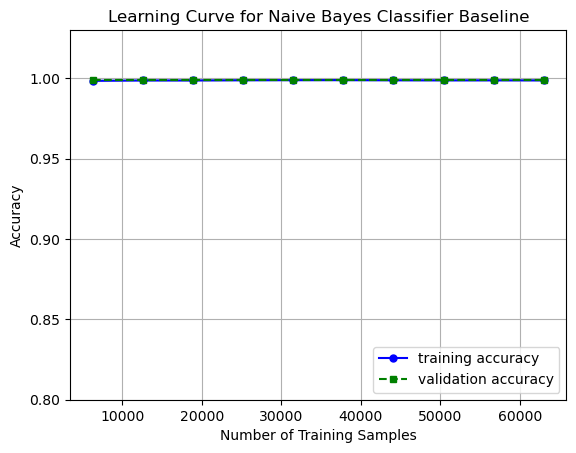

Wall time: 1.17 s


In [349]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_bnb,
                                                        X=X_train_mirror,
                                                        y=np.ravel(y_train_mirror),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Naive Bayes Classifier Baseline', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show( )

#### Validation Curve for Naive Bayes Classifier

Create a validation curve for the Naive Bayes Classifier baseline model to measure the accuracy for the training and validation sets for the alpha hyperparameter.

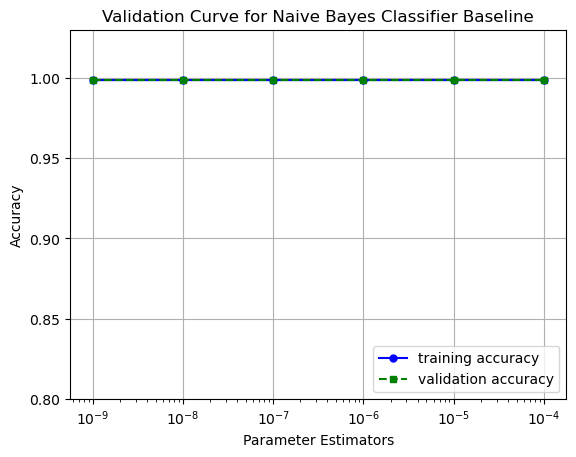

Wall time: 1.29 s


In [253]:
%%time

param_range = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
train_scores, test_scores = validation_curve(estimator=pipe_bnb,
                                            X=X_train_mirror,
                                            y=np.ravel(y_train_mirror),
                                            param_name='BNB__alpha',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Naive Bayes Classifier Baseline', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

#### Naive Bayes Classifier Confusion Matrix

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

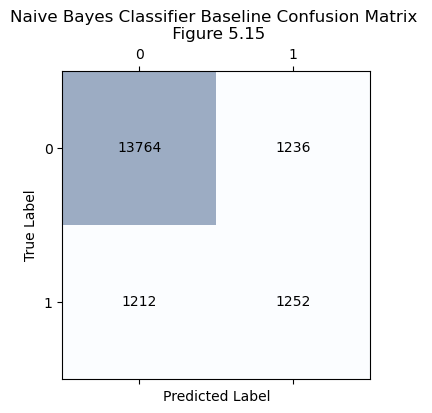

Wall time: 83.3 ms


In [342]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=bnb_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Classifier Baseline Confusion Matrix \n Figure 5.15')
plt.show()

### Undersampled Data

#### Grid Search Cross Validation for Naive Bayes Classifier with Undersampled data

Perform grid search cross validation for the Naive Bayes Classifier undersampled dataset to find the best hyperparameters for the alpha parameter.

In [223]:
%%time

alpha = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

bnb_grid = [{'BNB__alpha': alpha}]

pipe_bnb = Pipeline([('scl', StandardScaler()),
                    ('BNB', BernoulliNB())])

bnb_grid_cv_under = GridSearchCV(estimator=pipe_bnb, param_grid=bnb_grid, scoring='accuracy', cv=5, n_jobs=-1)

bnb_gs_under = bnb_grid_cv_under.fit(X_train_under, np.ravel(y_train_under))
print('Naive Bayes Undersampled Best Parameters: {}'.format(bnb_gs_under.best_params_))
print('Naive Bayes Undersampled Train Accuracy: {:.6f}'.format(bnb_gs_under.best_score_))

Naive Bayes Undersampled Best Parameters: {'BNB__alpha': 1e-09}
Naive Bayes Undersampled Train Accuracy: 0.806662
Wall time: 104 ms


#### Find the Test Accuracy, Precision, and Recall for the best Naive Bayes Classifier undersampled model

In [224]:
%%time

bnb_under_best_clf = bnb_gs_under.best_estimator_
bnb_under_best_clf.fit(X_train, np.ravel(y_train))
bnb_under_best_pred = bnb_under_best_clf.predict(X_test)

print('Naive Bayes Undersampled Test Accuracy: {:.6f}'.format(bnb_under_best_clf.score(X_test, np.ravel(y_test))))
print('Naive Bayes Undersampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=bnb_under_best_pred)))
print('Naive Bayes Undersampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=bnb_under_best_pred)))

Naive Bayes Undersampled Test Accuracy: 0.859826
Naive Bayes Undersampled Test Precision: 0.503215
Naive Bayes Undersampled Test Recall: 0.508117
Wall time: 41.7 ms


#### K-Fold Cross Validation for Naive Bayes Classifier with Undersampled Data

Perform  $k$-fold cross validation to find the best cross-validation accuracy for the Naive Bayes Classifier undersampled model.

In [254]:
%%time

pipe_under_bnb = Pipeline([('scl', StandardScaler()),
                         ('BNB', BernoulliNB(alpha=1e-09))])

bnb_under_scores = cross_val_score(estimator=pipe_under_bnb,
                              X=X_train_under,
                              y=np.ravel(y_train_under),
                              cv=10,
                              n_jobs=-1)

print('Naive Bayes Classifier Undersampled CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(bnb_under_scores), np.std(bnb_under_scores)))

Naive Bayes Classifier Undersampled CV Accuracy: 0.806 +/- 0.013
Wall time: 47.3 ms


#### Learning Curve for Naive Bayes Classifier with Undersampled Data

Create a learning curve for the Naive Bayes Classifier undersampled model to measure the training and validation accuracies based on the number of training samples.

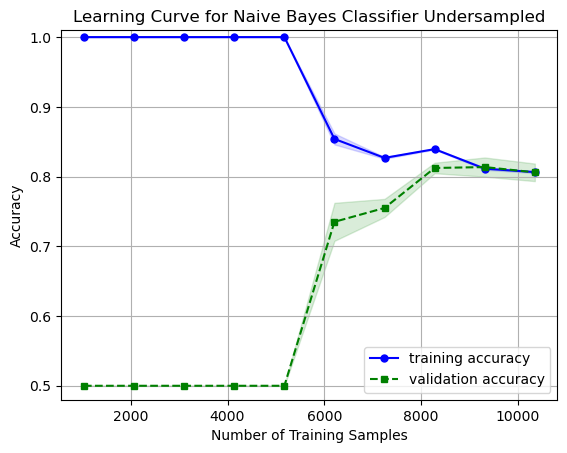

Wall time: 399 ms


In [259]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_under_bnb,
                                                        X=X_train_under,
                                                        y=np.ravel(y_train_under),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Naive Bayes Classifier Undersampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.48, 1.01])
plt.show( )

#### Validation Curve for Naive Bayes Classifier with Undersampled Data

Create a validation curve for the Naive Bayes Classifier undersampled model to measure the accuracy for the training and validation sets for the alpha hyperparameter.

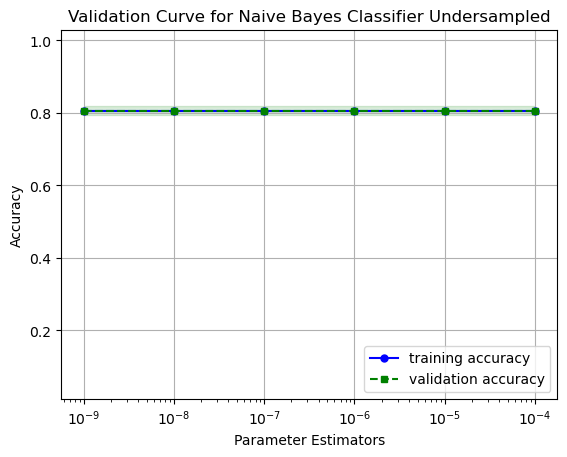

Wall time: 3.07 s


In [288]:
%%time

param_range = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
train_scores, test_scores = validation_curve(estimator=pipe_under_bnb,
                                            X=X_train_under,
                                            y=np.ravel(y_train_under),
                                            param_name='BNB__alpha',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Naive Bayes Classifier Undersampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1.03])
plt.show()

#### Confusion Matrix for Naive Bayes Classifier Undersampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

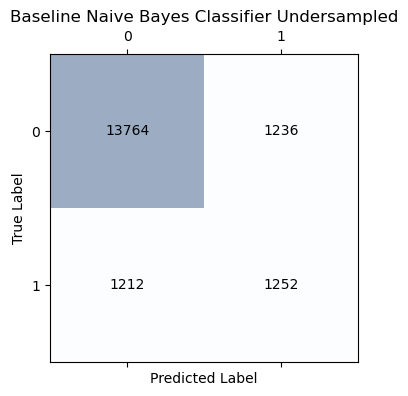

Wall time: 77.2 ms


In [261]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=bnb_under_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Naive Bayes Classifier Undersampled')
plt.show()

### Oversampled Data

#### Grid Search Cross Validation for Naive Bayes Classifier with Oversampled data

Perform grid search cross validation for the Naive Bayes Classifier oversampled dataset to find the best hyperparameters for the alpha parameter.

In [262]:
%%time

alpha = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

bnb_grid = [{'BNB__alpha': alpha}]

pipe_bnb = Pipeline([('scl', StandardScaler()),
                    ('BNB', BernoulliNB())])

bnb_grid_cv_over = GridSearchCV(estimator=pipe_bnb, param_grid=bnb_grid, scoring='accuracy', cv=5, n_jobs=-1)

bnb_gs_over = bnb_grid_cv_over.fit(X_train_over, np.ravel(y_train_over))
print('Naive Bayes Oversampled Best Parameters: {}'.format(bnb_gs_over.best_params_))
print('Naive Bayes Oversampled Train Accuracy: {:.6f}'.format(bnb_gs_over.best_score_))

Naive Bayes Oversampled Best Parameters: {'BNB__alpha': 1e-09}
Naive Bayes Oversampled Train Accuracy: 0.854548
Wall time: 452 ms


#### Find the Test Accuracy, Precision, and Recall for the best Naive Bayes Classifier oversampled model

In [263]:
%%time

bnb_over_best_clf = bnb_gs_over.best_estimator_
bnb_over_best_clf.fit(X_train, np.ravel(y_train))
bnb_over_best_pred = bnb_over_best_clf.predict(X_test)

print('Naive Bayes Oversampled Test Accuracy: {:.6f}'.format(bnb_over_best_clf.score(X_test, np.ravel(y_test))))
print('Naive Bayes Oversampled Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=bnb_over_best_pred)))
print('Naive Bayes Oversampled Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=bnb_over_best_pred))) 

Naive Bayes Oversampled Test Accuracy: 0.859826
Naive Bayes Oversampled Test Precision: 0.503215
Naive Bayes Oversampled Test Recall: 0.508117
Wall time: 38 ms


#### K-Fold Cross Validation for Naive Bayes Classifier with Oversampled Data

Perform  $k$-fold cross validation to find the best cross-validation accuracy for the Naive Bayes Classifier oversampled model.

In [264]:
%%time

pipe_over_bnb = Pipeline([('scl', StandardScaler()),
                         ('BNB', BernoulliNB())])

bnb_over_scores = cross_val_score(estimator=pipe_over_bnb,
                              X=X_train_over,
                              y=np.ravel(y_train_over),
                              cv=10,
                              n_jobs=-1)

print('Naive Bayes Classifier Oversampled CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(bnb_over_scores), np.std(bnb_over_scores)))

Naive Bayes Classifier Oversampled CV Accuracy: 0.855 +/- 0.003
Wall time: 234 ms


#### Learning Curve for Naive Bayes Classifier with Oversampled Data

Create a learning curve for the Naive Bayes Classifier oversampled model to measure the training and validation accuracies based on the number of training samples.

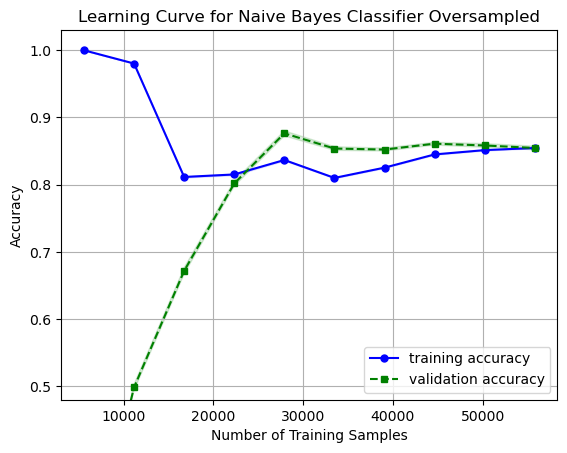

Wall time: 4.66 s


In [348]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_over_bnb,
                                                        X=X_train_over,
                                                        y=np.ravel(y_train_over),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Naive Bayes Classifier Oversampled', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.48, 1.03])
plt.show( )

#### Validation Curve for Naive Bayes Classifier with Oversampled Data

Create a validation curve for the Naive Bayes Classifier oversampled model to measure the accuracy for the training and validation sets for the alpha hyperparameter.

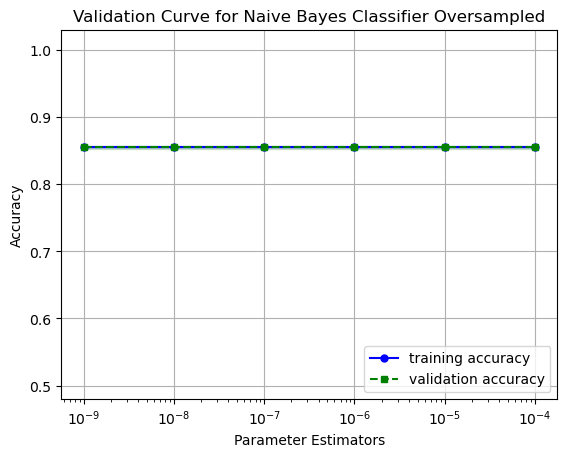

Wall time: 1.24 s


In [267]:
%%time

param_range = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
train_scores, test_scores = validation_curve(estimator=pipe_over_bnb,
                                            X=X_train_over,
                                            y=np.ravel(y_train_over),
                                            param_name='BNB__alpha',
                                            param_range=param_range,
                                            cv=10,
                                            n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Naive Bayes Classifier Oversampled', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.48, 1.03])
plt.show()

#### Confusion Matrix for Naive Bayes Classifier Oversampled

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

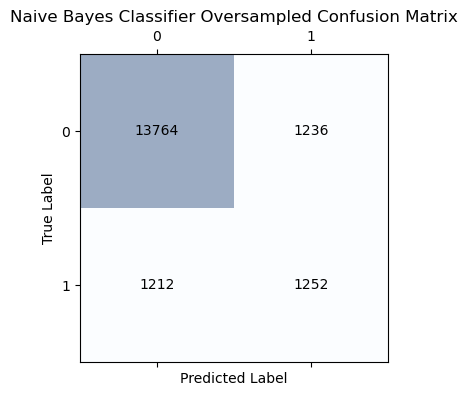

Wall time: 80 ms


In [347]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=bnb_over_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Classifier Oversampled Confusion Matrix')
plt.show()

### SMOTE Data

#### Grid Search Cross Validation for Naive Bayes Classifier with SMOTE data

Perform grid search cross validation for the Naive Bayes Classifier SMOTE dataset to find the best hyperparameters for the alpha parameter.

In [269]:
%%time

alpha = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

bnb_grid = [{'BNB__alpha': alpha}]

pipe_bnb = Pipeline([('scl', StandardScaler()),
                    ('BNB', BernoulliNB())])

bnb_grid_cv_smote = GridSearchCV(estimator=pipe_bnb, param_grid=bnb_grid, scoring='accuracy', cv=5, n_jobs=-1)

bnb_gs_smote = bnb_grid_cv_smote.fit(X_train_smote, np.ravel(y_train_smote))
print('Naive Bayes SMOTE Best Parameters: {}'.format(bnb_gs_smote.best_params_))
print('Naive Bayes SMOTE Train Accuracy: {:.6f}'.format(bnb_gs_smote.best_score_))

Naive Bayes SMOTE Best Parameters: {'BNB__alpha': 1e-09}
Naive Bayes SMOTE Train Accuracy: 0.806462
Wall time: 400 ms


#### Find the Test Accuracy, Precision, and Recall for the best Naive Bayes Classifier SMOTE model

In [270]:
%%time

bnb_smote_best_clf = bnb_gs_smote.best_estimator_
bnb_smote_best_clf.fit(X_train, np.ravel(y_train))
bnb_smote_best_pred = bnb_smote_best_clf.predict(X_test)

print('Naive Bayes SMOTE Test Accuracy: {:.6f}'.format(bnb_smote_best_clf.score(X_test, np.ravel(y_test))))
print('Naive Bayes SMOTE Test Precision: {:.6f}'.format(precision_score(y_true=np.ravel(y_test), y_pred=bnb_smote_best_pred)))
print('Naive Bayes SMOTE Test Recall: {:.6f}'.format(recall_score(y_true=np.ravel(y_test), y_pred=bnb_smote_best_pred))) 

Naive Bayes SMOTE Test Accuracy: 0.859826
Naive Bayes SMOTE Test Precision: 0.503215
Naive Bayes SMOTE Test Recall: 0.508117
Wall time: 37 ms


#### K-Fold Cross Validation for Naive Bayes Classifier with SMOTE Data

Perform  $k$-fold cross validation to find the best cross-validation accuracy for the Naive Bayes Classifier Smote model.

In [271]:
%%time

pipe_smote_bnb = Pipeline([('scl', StandardScaler()),
                         ('BNB', BernoulliNB())])

bnb_smote_scores = cross_val_score(estimator=pipe_smote_bnb,
                              X=X_train_smote,
                              y=np.ravel(y_train_smote),
                              cv=10,
                              n_jobs=-1)

print('Naive Bayes Classifier SMOTE CV Accuracy: {:.3f} +/- {:.3f}'.format(np.mean(bnb_smote_scores), np.std(bnb_smote_scores)))

Naive Bayes Classifier SMOTE CV Accuracy: 0.807 +/- 0.005
Wall time: 215 ms


#### Learning Curve for Naive Bayes Classifier with SMOTE Data

Create a learning curve for the Naive Bayes Classifier SMOTE model to measure the training and validation accuracies based on the number of training samples.

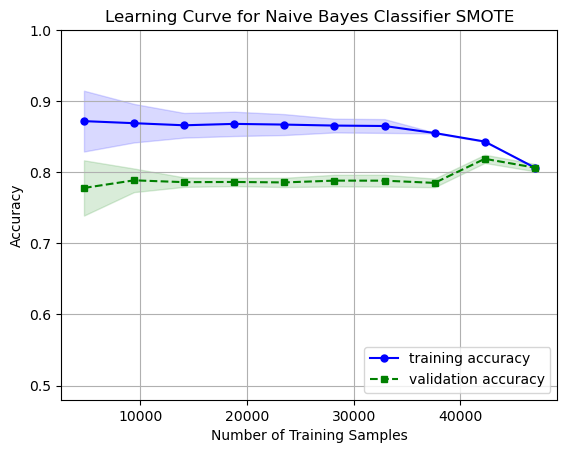

Wall time: 845 ms


In [273]:
%%time

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_smote_bnb,
                                                        X=X_train_smote,
                                                        y=np.ravel(y_train_smote),
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curve for Naive Bayes Classifier SMOTE', fontsize='large')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.48, 1.0])
plt.show( )

#### Validation Curve for Naive Bayes Classifier with SMOTE Data

Create a validation curve for the Naive Bayes Classifier SMOTE model to measure the accuracy for the training and validation sets for the alpha hyperparameter.

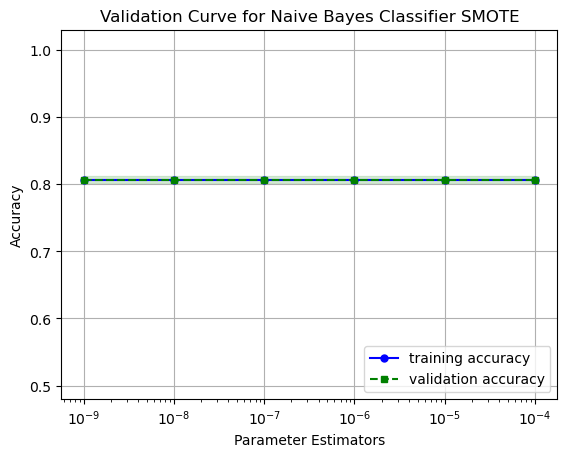

Wall time: 2.54 s


In [274]:
%%time

param_range = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
train_scores, test_scores = validation_curve(estimator=pipe_smote_bnb,
                                            X=X_train_smote,
                                            y=np.ravel(y_train_smote),
                                            param_name='BNB__alpha',
                                            param_range=param_range,
                                            cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Validation Curve for Naive Bayes Classifier SMOTE', fontsize='large')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.48, 1.03])
plt.show()

#### Confusion Matrix for Naive Bayes Classifier SMOTE

Create a confusion matrix to plot the true positive, false positive, true negative and false negative.

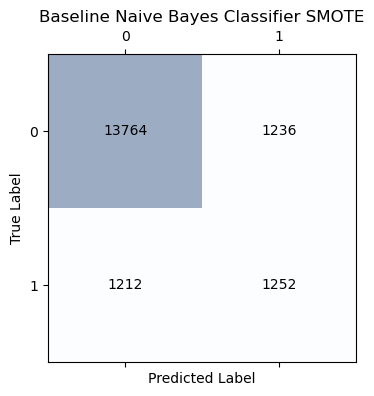

Wall time: 75.5 ms


In [275]:
%%time

confmat = confusion_matrix(y_true=y_test, y_pred=bnb_smote_best_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Naive Bayes Classifier SMOTE')
plt.show()

### AUC ROC Curve for Best Naive Bayes Classifier

Create a plot of the Area Under the Curve Receiver Operator Curve to plot the true positive rate and false positive rate for the best performing model for the Naive Bayes Classifier baseline, undersampled, oversampled, and SMOTE models.

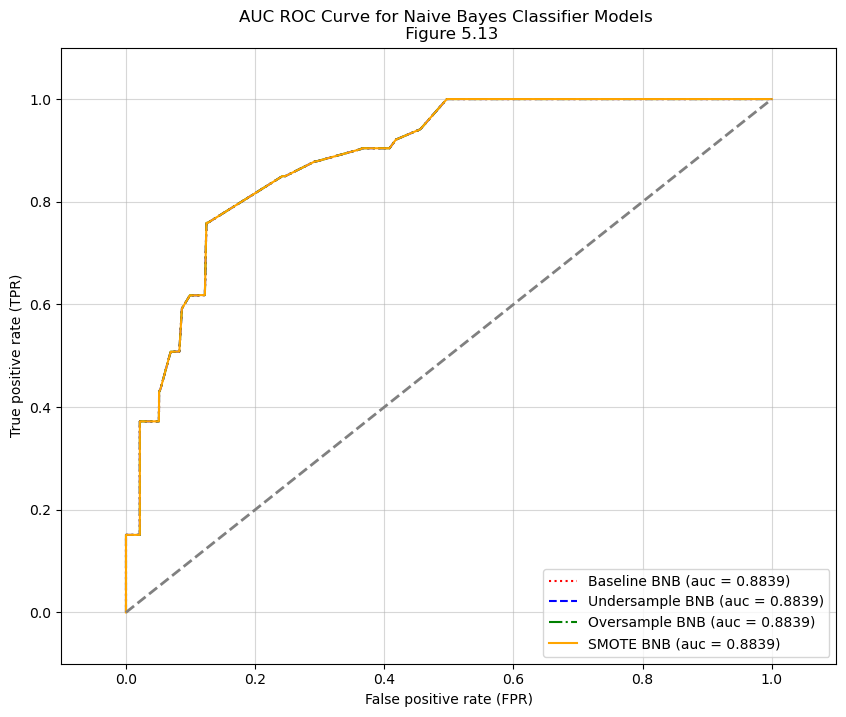

Wall time: 171 ms


In [359]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [bnb_best_clf, bnb_under_best_clf, bnb_over_best_clf, bnb_smote_best_clf]
clf_labels = ['Baseline BNB', 'Undersample BNB', 'Oversample BNB', 'SMOTE BNB']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.title("AUC ROC Curve for Naive Bayes Classifier Models \n Figure 5.13", fontsize="large")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Precision-Recall Curve for Best Naive Bayes Classifier Models

Create the Precision-Recall Curve to plot the precision and recall for the best performing Naive Bayes Classifier baseline, undersampled, oversampled, and SMOTE models.

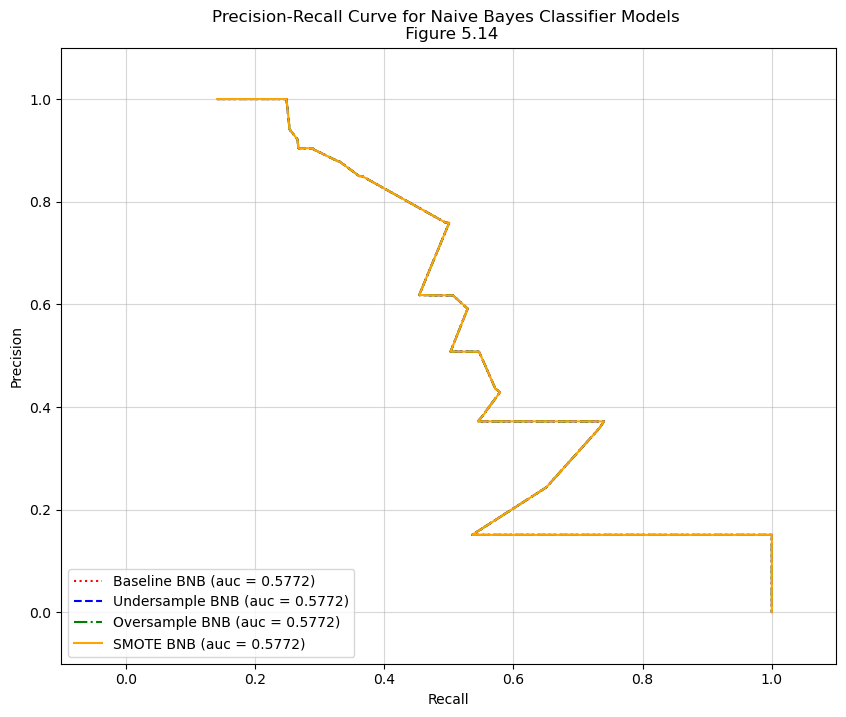

Wall time: 180 ms


In [361]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [bnb_best_clf, bnb_under_best_clf, bnb_over_best_clf, bnb_smote_best_clf]
clf_labels = ['Baseline BNB', 'Undersample BNB', 'Oversample BNB', 'SMOTE BNB']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(lr_recall, lr_precision)
    plt.plot(lr_precision, lr_recall, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.title("Precision-Recall Curve for Naive Bayes Classifier Models \n Figure 5.14", fontsize="large")
plt.legend(loc='lower left')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Table with Naive Bayes Classifier Model Results

Create a table of the Naive Bayes Classifier baseline, undersampled, oversampled, and SMOTE training and test accuracy scores, test precision, test recall and the best parameters.

In [278]:
%%time

baseline_train_acc = bnb_gs.best_score_
baseline_acc = bnb_best_clf.score(X_test, np.ravel(y_test))
baseline_cv_acc = '0.999 +/- 0.000'
baseline_cv_time = '245 ms'
baseline_prec = precision_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)
baseline_recall = recall_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)
baseline_params = bnb_gs.best_params_

undersamp_train_acc = bnb_gs_under.best_score_
undersamp_acc = bnb_under_best_clf.score(X_test, np.ravel(y_test))
undersamp_cv_acc = '0.806 +/- 0.013'
undersamp_cv_time = '51.7 ms'
undersamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=bnb_under_best_pred)
undersamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=bnb_under_best_pred)
undersamp_params = bnb_gs_under.best_params_

oversamp_train_acc = bnb_gs_over.best_score_
oversamp_acc = bnb_over_best_clf.score(X_test, np.ravel(y_test))
oversamp_cv_acc = '0.855 +/- 0.003'
oversamp_cv_time = '226 ms'
oversamp_prec = precision_score(y_true=np.ravel(y_test), y_pred=bnb_over_best_pred)
oversamp_recall = recall_score(y_true=np.ravel(y_test), y_pred=bnb_over_best_pred)
oversamp_params = bnb_gs_over.best_params_

smote_train_acc = bnb_gs_smote.best_score_
smote_acc = bnb_smote_best_clf.score(X_test, np.ravel(y_test))
smote_cv_acc = '0.807 +/- 0.005'
smote_cv_time = '215 ms'
smote_prec = precision_score(y_true=np.ravel(y_test), y_pred=bnb_smote_best_pred)
smote_recall = recall_score(y_true=np.ravel(y_test), y_pred=bnb_smote_best_pred)
smote_params = bnb_gs_smote.best_params_

data = {'Naive Bayes Classifier Baseline':[baseline_train_acc, baseline_acc, baseline_cv_acc, baseline_cv_time, baseline_prec, baseline_recall, baseline_params],
       'Naive Bayes Classifier Undersampled':[undersamp_train_acc, undersamp_acc, undersamp_cv_acc, undersamp_cv_time, undersamp_prec, undersamp_recall, undersamp_params],
       'Naive Bayes Classifier Oversampled':[oversamp_train_acc, oversamp_acc, oversamp_cv_acc, oversamp_cv_time, oversamp_prec, oversamp_recall, oversamp_params],
       'Naive Bayes Classifier SMOTE':[smote_train_acc, smote_acc, smote_cv_acc, smote_cv_time, smote_prec, smote_recall, smote_params]}
ind = ['Train Accuracy', 'Test Accuracy', 'Test CV Accuracy', 'CV Wait Time', 'Test Precision', 'Test Recall', 'Best Parameters']
bnb_df = pd.DataFrame(data=data, index=ind)
bnb_df

Wall time: 52.4 ms


,Naive Bayes Classifier Baseline,Naive Bayes Classifier Undersampled,Naive Bayes Classifier Oversampled,Naive Bayes Classifier SMOTE
Train Accuracy,0.862083,0.806662,0.854548,0.806462
Test Accuracy,0.859826,0.859826,0.859826,0.859826
Test CV Accuracy,0.999 +/- 0.000,0.806 +/- 0.013,0.855 +/- 0.003,0.807 +/- 0.005
CV Wait Time,245 ms,51.7 ms,226 ms,215 ms
Test Precision,0.503215,0.503215,0.503215,0.503215
Test Recall,0.508117,0.508117,0.508117,0.508117
Best Parameters,{'BNB__alpha': 1e-09},{'BNB__alpha': 1e-09},{'BNB__alpha': 1e-09},{'BNB__alpha': 1e-09}


In [280]:
bnb_df.to_excel("bnb_df.xlsx", index=True)

## Overall Model Results

* Logistic Regression: The Logistic Regression Oversampled and SMOTE Models performed better than the Baseline and Undersampled Models. The accuracy of the Oversampled Model was slightly better at $96.15 \%$ than the SMOTE model at $96.11 |%$. However, the SMOTE Model performs more consistently with the misclassification error rates. While the precision score of the Oversampled Model is higher by $10 \%$ than the SMOTE Model, the recall score is $10 \%$ lower than the SMOTE Model. When the AUC ROC Curve is viewed for all four Logistic Regression Models, Baseline and SMOTE Models have a much higher area under the curve then the Oversampled and Undersampled. When the Precision-Recall Curve is reviewed it yields similar results, with the Baseline and SMOTE performing better than the Undersampled and Oversampled Models. With such a drastic twenty point swing between the precision and recall and the better performance with the AUC ROC and Precision-Recall Curves, the decision was made to compare the Logistic Regression SMOTE Model against the Random Forests, Support Vector Machines and Naive Bayes Classifier.  
  

* Random Forests: The Random Forests SMOTE Model performed the best of all four Random Forests Models. While the accuracy is $99.35 \%$ which is on;y one-hundredth of a percent higher than the Oversampled Model, the SMOTE Model was more consistent in the misclassification error rate with a precision score of $97.23 \%$ and a recall score of $98.25 \%$. This indicates the SMOTE Model correctly classifies true positives and true negatives nine out of ten times. The AUC ROC Curve and Precision-Recall Curve for the four Random Forests Models do not show much useful information as all four models appear to perform similarly on both graphs. Therefore, the Random Forests SMOTE Model will be compared against the Logistic Regression, Support Vector Machines and Naive Bayes Classifier.


* Support Vector Machines: The Support Vector Machines Undersampled Model performed the best of all four Support Vector Machines Models. The accuracy of the Undersampled Model was $99.22 \%$, about one-tenth of a percent higher than both the Baseline and SMOTE Models. While all three of the other Models have slightly higher precision scores, ranging between two-tenths of a percent up to one percent higher. The recall score is at least five-tenths of a percent higher than any of the other Models. When we review the AUC ROC Curve for the Support Vector Machine Models, the Undersampled and SMOTE appear to perform higher than either the Baseline or Oversampled Models. The Precision-Recall Curve shows similar results, where the Undersampled and SMOTE Models outperform the Baseline and Oversampled Models. When choosing which model to compare with the other Models, the decision was to compare the more consistent models in terms of their misclassification error rates and thus the Undersampled Model was chosen.


* Naive Bayes Classifier: The four Naive Bayes Classifiers performed differently for the training accuracy of the models, however when the test accuracies of all four models are compared they are the same. Similarly the precision and recall scores for all four models are the same.This could be due to errors in the building of the model. When viewing the AUC ROC Curve for the Naive Bayes Classifier, the four Models are not distinguishable from each other. In the same manner, when the Precision-Recall Curve is viewed the four Models cannot be separated in terms of performance. The decision was made to compare the Baseline Model, with an accuracy of $85.98 \%$, precision of $50.32 \%$ and recall of $50.81 \%$, against the Logistic Regression, Random Forests and Support Vector Machines.

### AUC ROC Curve for Best Models (Logistic Regression, Random Forests, Support Vector Machines, Naive Bayes Classifier)

Create a plot of the Area Under the Curve Receiver Operator Curve to plot the true positive rate and false positive rate for the best performing model for the Logistic Regression, Random Forests, Support Vector Machines, and Naive Bayes Classifier models.

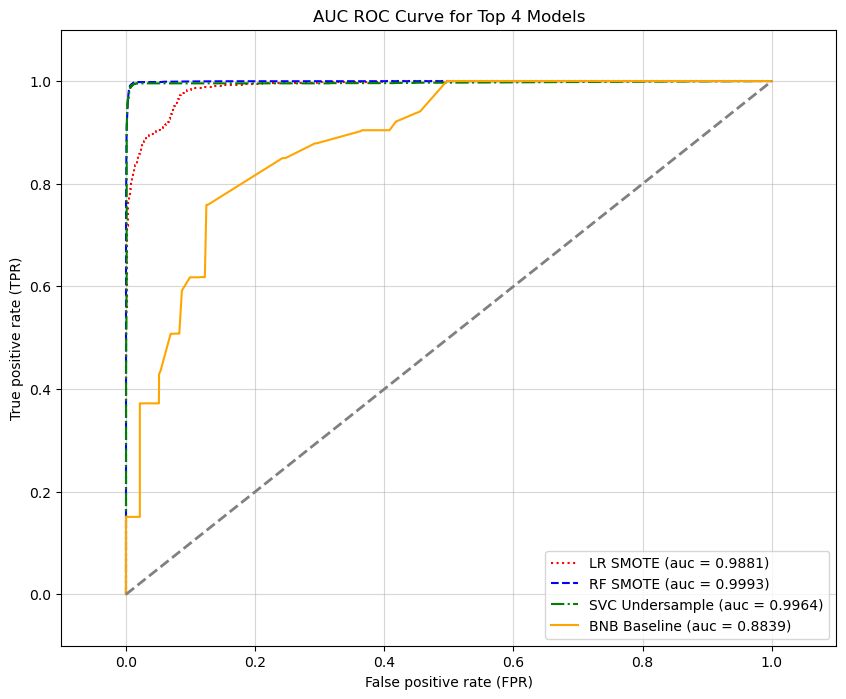

Wall time: 1.93 s


In [354]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [lr_smote_best_clf, RF_smote_best_clf, SVC_under_best_clf, bnb_best_clf]
clf_labels = ['LR SMOTE', 'RF SMOTE', 'SVC Undersample', 'BNB Baseline']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.title("AUC ROC Curve for Top 4 Models", fontsize="large")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Precision-Recall Curve for Best Models (Logistic Regression, Random Forests, Support Vector Machines, Naive Bayes Classifier)

Create the Precision-Recall Curve to plot the precision and recall for the best performing model for the Logistic Regression, Random Forests, Support Vector Machines, and Naive Bayes Classifier models.

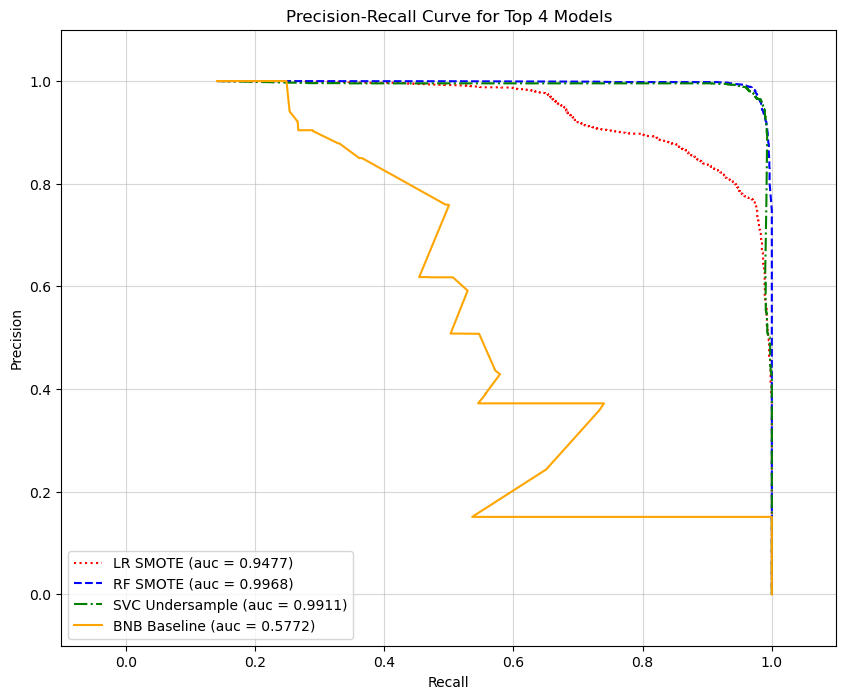

Wall time: 2.05 s


In [355]:
%%time

fig, ax = plt.subplots(figsize=(10,8))
all_clf = [lr_smote_best_clf, RF_smote_best_clf, SVC_under_best_clf, bnb_best_clf]
clf_labels = ['LR SMOTE', 'RF SMOTE', 'SVC Undersample', 'BNB Baseline']
colors = ['red', 'blue', 'green', 'orange']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.predict_proba(X_test)[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
    roc_auc = auc(lr_recall, lr_precision)
    plt.plot(lr_precision, lr_recall, color=clr, linestyle=ls,
            label = '%s (auc = %0.4f)'% (label, roc_auc))
plt.title("Precision-Recall Curve for Top 4 Models", fontsize="large")
plt.legend(loc='lower left')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Table with Best Models (Logistic Regression, Random Forests, Support Vector Machines, Naive Bayes Classifier)

Create a table of the best performing Logistic Regression, Random Forests, Support Vector Machines and Naive Bayes Classifier training and test accuracy scores, test precision, test recall and the best parameters.

In [284]:
%%time

smote_lr_train_acc = lr_gs_smote.best_score_
smote_lr_acc = lr_smote_best_clf.score(X_test, y_test)
smote_lr_cv_acc = '0.940 +/- 0.005'
smote_lr_cv_time = '46.9 s'
smote_lr_prec = precision_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)
smote_lr_recall = recall_score(y_true=np.ravel(y_test), y_pred=lr_smote_best_pred)
smote_lr_params = lr_gs_smote.best_params_

smote_rf_train_acc = RF_gs_smote.best_score_
smote_rf_acc = RF_smote_best_clf.score(X_test, np.ravel(y_test))
smote_rf_cv_acc = '0.996 +/- 0.001'
smote_rf_cv_time = '11.3 s'
smote_rf_prec = precision_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred)
smote_rf_recall = recall_score(y_true=np.ravel(y_test), y_pred=RF_smote_best_pred)
smote_rf_params = RF_gs_smote.best_params_

under_svm_train_acc = SVC_gs_under.best_score_
under_svm_acc = SVC_under_best_clf.score(X_test, np.ravel(y_test))
under_svm_cv_acc = '0.985 +/- 0.002'
under_svm_cv_time = '8.73 s'
under_svm_prec = precision_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)
under_svm_recall = recall_score(y_true=np.ravel(y_test), y_pred=SVC_under_best_pred)
under_svm_params = SVC_gs_under.best_params_

baseline_bnb_train_acc = bnb_gs.best_score_
baseline_bnb_acc = bnb_best_clf.score(X_test, np.ravel(y_test))
baseline_bnb_cv_acc = '0.999 +/- 0.000'
baseline_bnb_cv_time = '245 ms'
baseline_bnb_prec = precision_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)
baseline_bnb_recall = recall_score(y_true=np.ravel(y_test), y_pred=bnb_best_pred)
baseline_bnb_params = bnb_gs.best_params_

data = {'Logistic Regression SMOTE':[smote_lr_train_acc, smote_lr_acc, smote_lr_cv_acc, smote_lr_cv_time, smote_lr_prec, smote_lr_recall, smote_lr_params],
       'Random Forests SMOTE':[smote_rf_train_acc, smote_rf_acc, smote_rf_cv_acc, smote_rf_cv_time, smote_rf_prec, smote_rf_recall, smote_rf_params],
       'Support Vector Machines Undersampled':[under_svm_train_acc, under_svm_acc, under_svm_cv_acc, under_svm_cv_time, under_svm_prec, under_svm_recall, under_svm_params],
       'Naive Bayes Classifier SMOTE':[baseline_bnb_train_acc, baseline_bnb_acc, baseline_bnb_cv_acc, baseline_bnb_cv_time, baseline_bnb_prec, baseline_bnb_recall, baseline_bnb_params]}
ind = ['Train Accuracy', 'Test Accuracy', 'Test CV Accuracy', 'CV Wait Time', 'Test Precision', 'Test Recall', 'Best Parameters']
combine_df = pd.DataFrame(data=data, index=ind)
combine_df

Wall time: 1.92 s


,Logistic Regression SMOTE,Random Forests SMOTE,Support Vector Machines Undersampled,Naive Bayes Classifier SMOTE
Train Accuracy,0.939861,0.99548,0.985128,0.862083
Test Accuracy,0.961063,0.993587,0.992213,0.859826
Test CV Accuracy,0.940 +/- 0.005,0.996 +/- 0.001,0.985 +/- 0.002,0.999 +/- 0.000
CV Wait Time,46.9 s,11.3 s,8.73 s,245 ms
Test Precision,0.854531,0.972289,0.957907,0.503215
Test Recall,0.872565,0.982549,0.988231,0.508117
Best Parameters,"{'LR__C': 1.0, 'LR__penalty': 'l1'}","{'RF__criterion': 'entropy', 'RF__max_features...","{'SVM__C': 40000.0, 'SVM__gamma': 0.1}",{'BNB__alpha': 1e-09}


In [285]:
combine_df.to_excel("combine_df.xlsx", index=True)

## Final Model Choice

When the AUC ROC Curve is viewed for the top performing model from each Model class, both the Random Forests SMOTE and Support Vector Machines Undersampled models show higher areas under the curve with scores of $99..9 \%$ and $99.6 \%$. When we review the Precision-Recall Curve the Random Forests SMOTE model has a slightly higher area under the curve than the Support Vector Machines Undersampled model with $99.7 \%$ and $99.1 \%$, respectively. When the model metrics are reviewed the Random Forests SMOTE model has a higher accuracy at $99.37 \%$ than the Support Vector Machines Undersampled model's $99.22 \%$. The precision score for the Random Forests SMOTE model is also two percent higher than the Support Vector Machines Undersampled model, with a score of $97.23 \%$. The results are different for the recall score, with the Support Vector Machines Undersampled model performing better by a difference of $0.57 \%$. Based on the AUC ROC Curve, Precision-Recall Curve, and metrics discussed above, the model which appears to performs the best overall is the Random Forests SMOTE Model.  With the highest accuracy and precision scores, along with its computational efficiency this will be the model recommended to the business stakeholders.